In [1]:
import pandas as pd
import numpy as np
from PyALE import ale
import joblib
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [2]:
xgb = joblib.load("models/XGBClassifier_ohe_mode_allcat.pkl")
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df_ohe = pd.read_csv("data/ohe_mode_allcat.csv")

ohe_col = ['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp']

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator Pipeline from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:299: UserWarning: Trying to unpickle estimator StandardScaler from version 1.2.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For

In [3]:
df_ohe.drop(columns=['Unnamed: 0'],inplace=True)

In [4]:
def fillnull(col):
    col.fillna(col.value_counts().index[0], inplace=True)
    return col

df = df.apply(lambda col: fillnull(col))

In [5]:
df_ohe.columns

Index(['destination_Home', 'destination_No Urgent Place', 'destination_Work',
       'passanger_Alone', 'passanger_Friend(s)', 'passanger_Kid(s)',
       'passanger_Partner', 'weather_Rainy', 'weather_Snowy', 'weather_Sunny',
       ...
       'toCoupon_GEQ5min_1', 'toCoupon_GEQ15min_0', 'toCoupon_GEQ15min_1',
       'toCoupon_GEQ25min_0', 'toCoupon_GEQ25min_1', 'direction_same_0',
       'direction_same_1', 'direction_opp_0', 'direction_opp_1', 'Y'],
      dtype='object', length=128)

In [6]:
# df transformation
df['temperature'] = df['temperature'].astype(object)
for i in df.columns[:-1]:
    df[i] = f'{i}_' + df[i].astype(str)

In [7]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,destination_No Urgent Place,passanger_Alone,weather_Sunny,temperature_55,time_2PM,coupon_Restaurant(<20),expiration_1d,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_0,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,1
1,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_10AM,coupon_Coffee House,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_0,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0
2,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_10AM,coupon_Carry out & Take away,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,1
3,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_2PM,coupon_Coffee House,expiration_2h,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0
4,destination_No Urgent Place,passanger_Friend(s),weather_Sunny,temperature_80,time_2PM,coupon_Coffee House,expiration_1d,gender_Female,age_21,maritalStatus_Unmarried partner,...,CoffeeHouse_never,CarryAway_1~3,RestaurantLessThan20_4~8,Restaurant20To50_1~3,toCoupon_GEQ5min_1,toCoupon_GEQ15min_1,toCoupon_GEQ25min_0,direction_same_0,direction_opp_1,0


In [8]:
from pyale import hyeni_pyale

PyALE._ALE_generic:INFO: categorical feature detected.


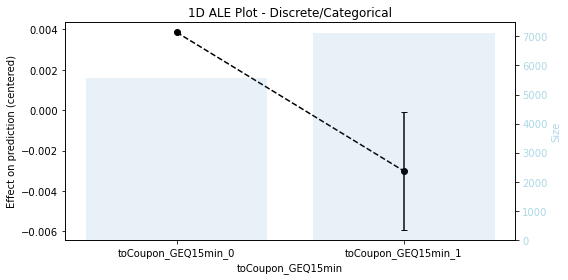

In [9]:
ale_col = 'toCoupon_GEQ15min'
ohe = OneHotEncoder()
coded_feature = pd.DataFrame(ohe.fit_transform(df[[ale_col]]).toarray(),columns=[x for i in ohe.categories_ for x in i])
features = df_ohe.columns.tolist()
features.remove("Y")

X_feat_raw = df_ohe.drop(coded_feature.columns.to_list(), axis=1, inplace=False).copy()
X_feat_raw

one_hot_encoder = OneHotEncoder().fit(df[[ale_col]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

ale_eff = ale(
        X=pd.concat([X_feat_raw,df[ale_col]], axis=1).drop(columns=['Y']),
        model=xgb.best_estimator_.named_steps.model,
        feature=[ale_col],
        encode_fun=onehot_encode,
        predictors=features,
)

PyALE._ALE_generic:INFO: categorical feature detected.


,eff,size,lowerCI_95%,upperCI_95%
temperature,,,,
temperature_80,-0.002445,6528,NaN,NaN
temperature_55,0.009804,3840,0.007003,0.012605
temperature_30,-0.009364,2316,-0.014106,-0.004622


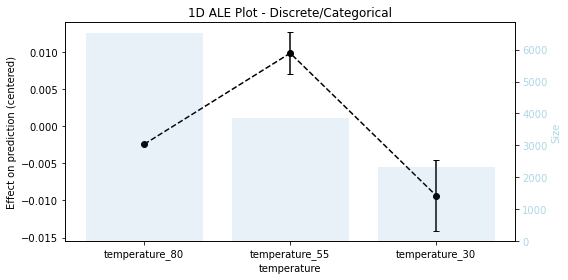

In [10]:
hyeni_pyale(df,df_ohe,xgb,'temperature')

In [13]:
import matplotlib as mpl
mpl.style.use('default')

PyALE._ALE_generic:INFO: categorical feature detected.


destination


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


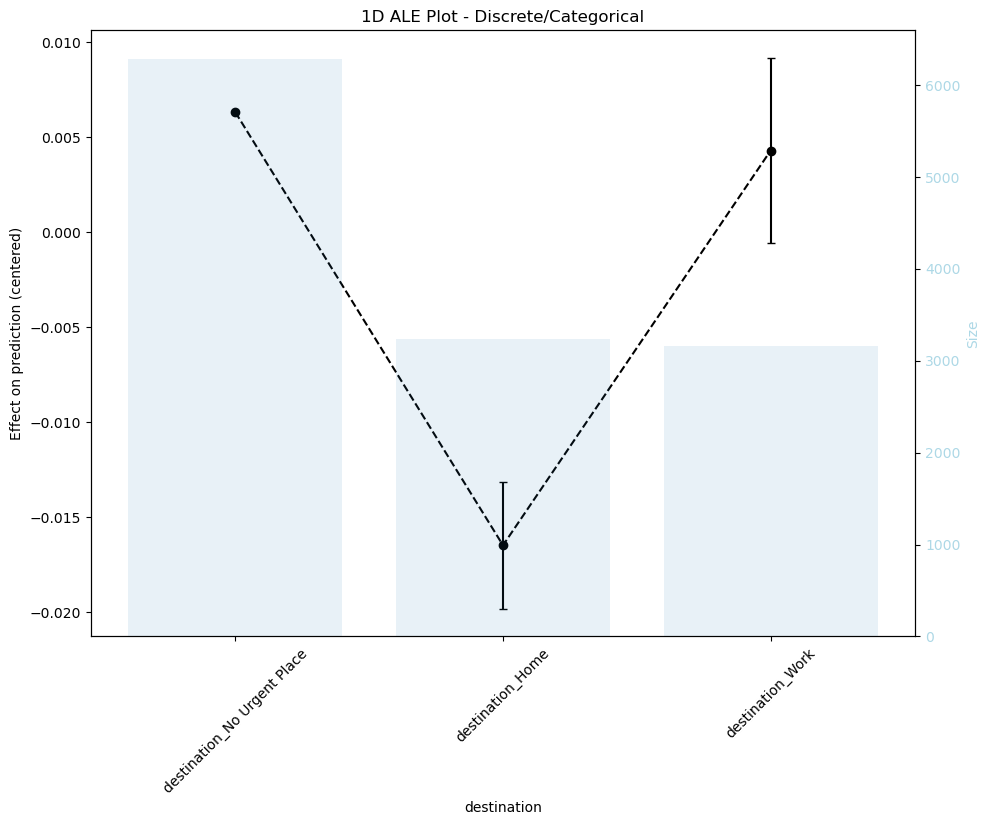

PyALE._ALE_generic:INFO: categorical feature detected.


passanger


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


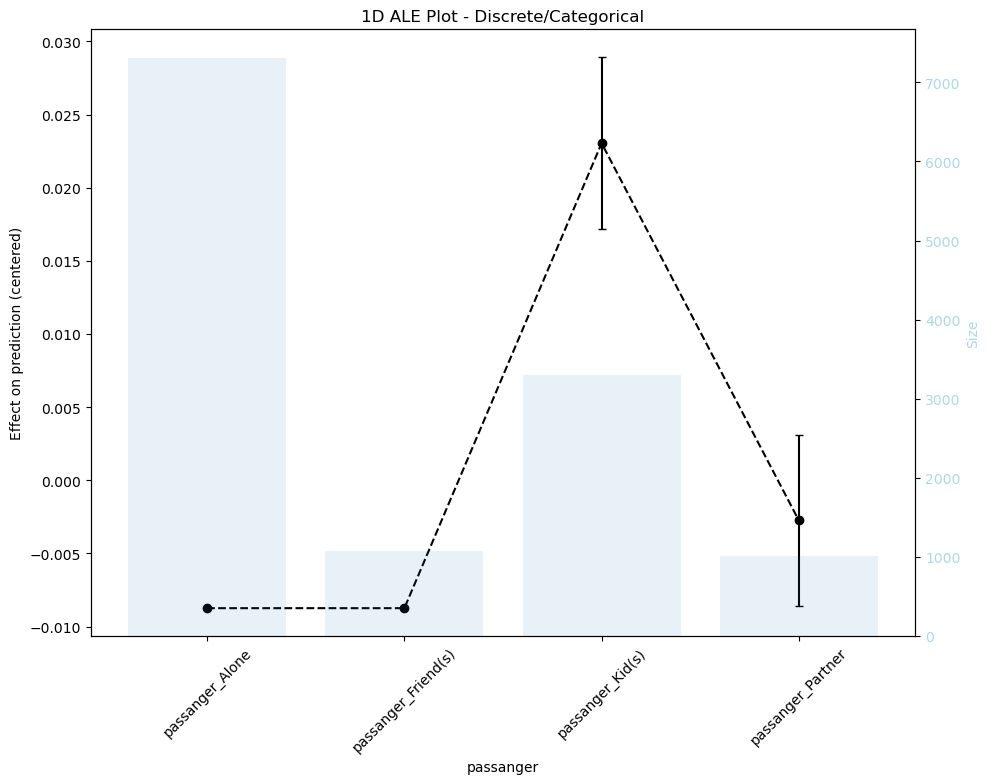

PyALE._ALE_generic:INFO: categorical feature detected.


weather


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


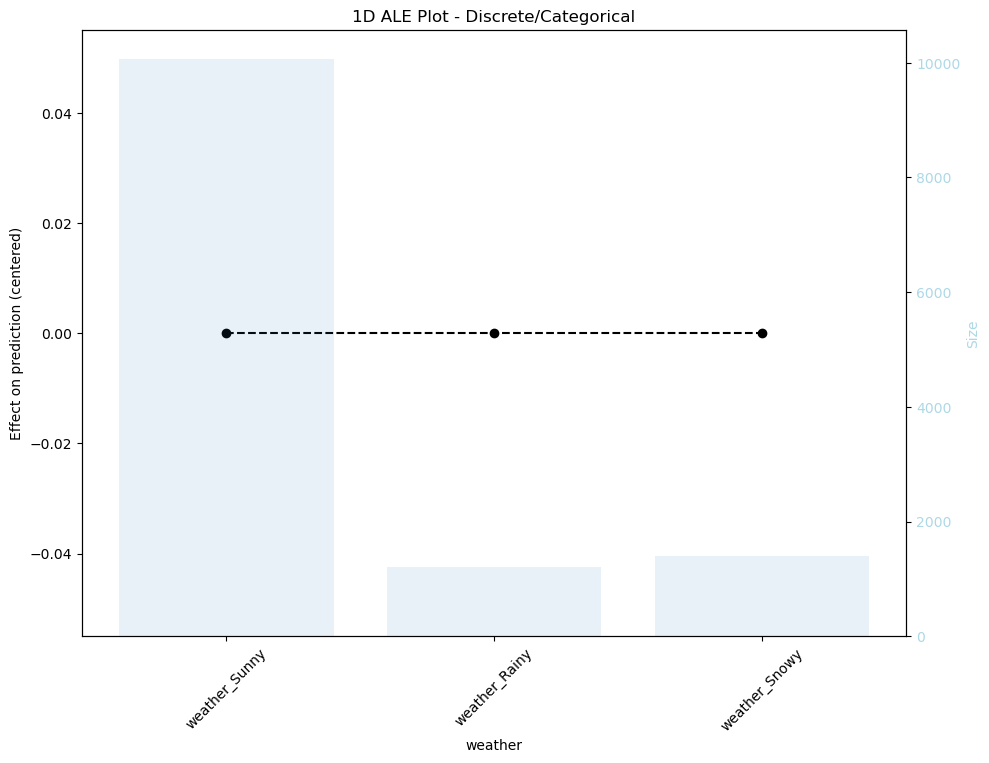

PyALE._ALE_generic:INFO: categorical feature detected.


temperature


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


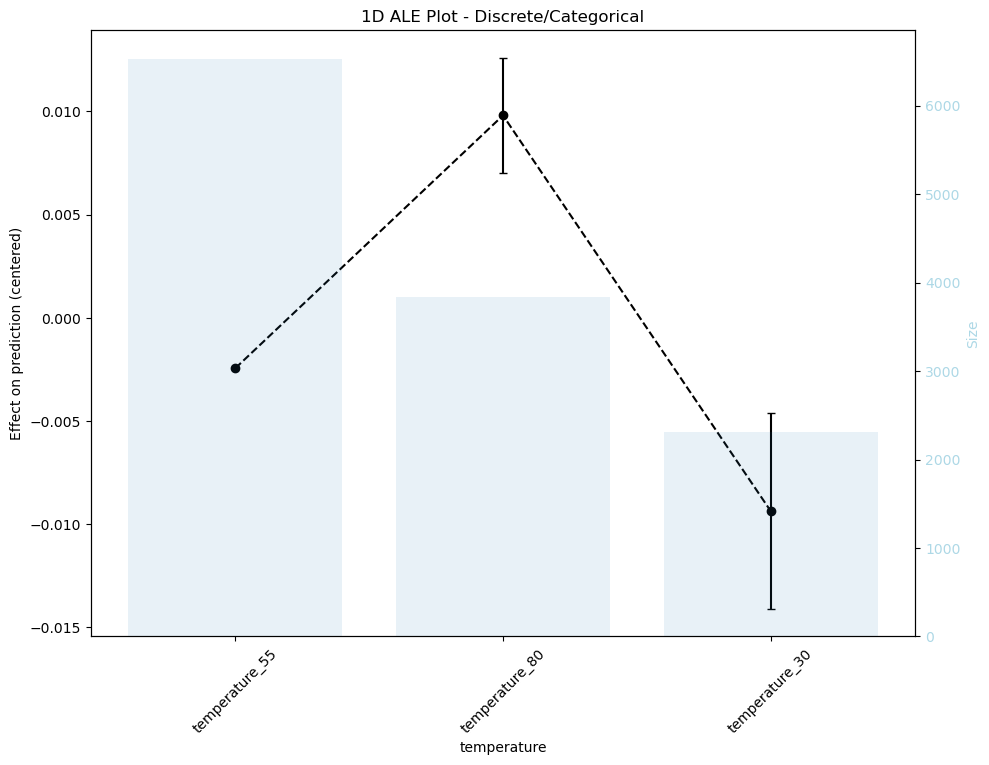

PyALE._ALE_generic:INFO: categorical feature detected.


time


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


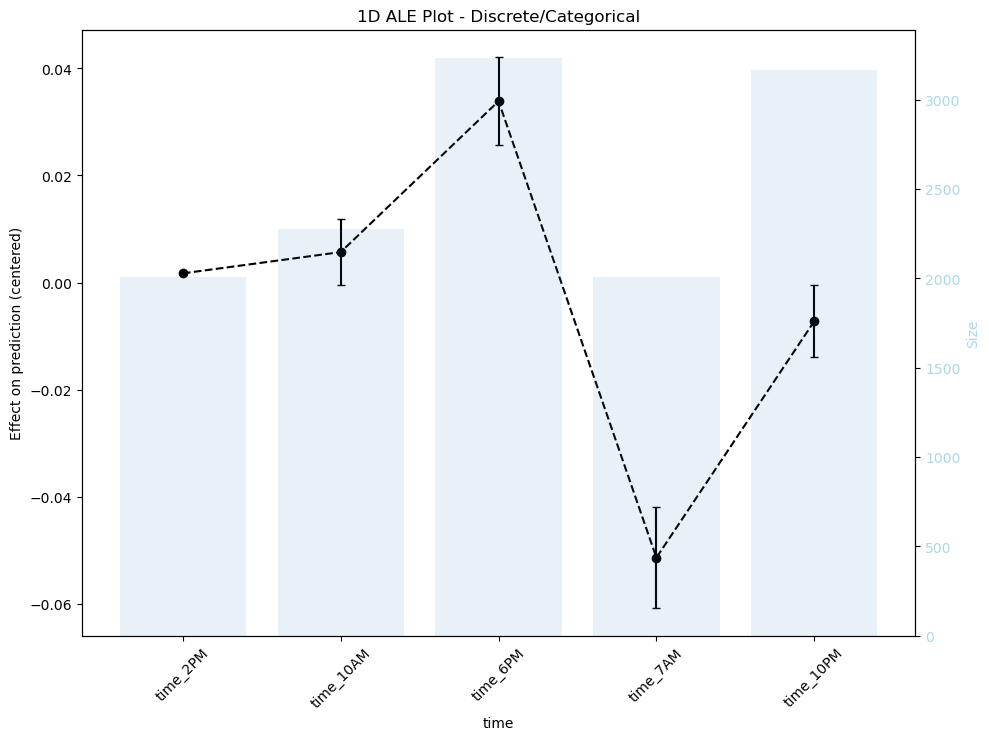

PyALE._ALE_generic:INFO: categorical feature detected.


coupon


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


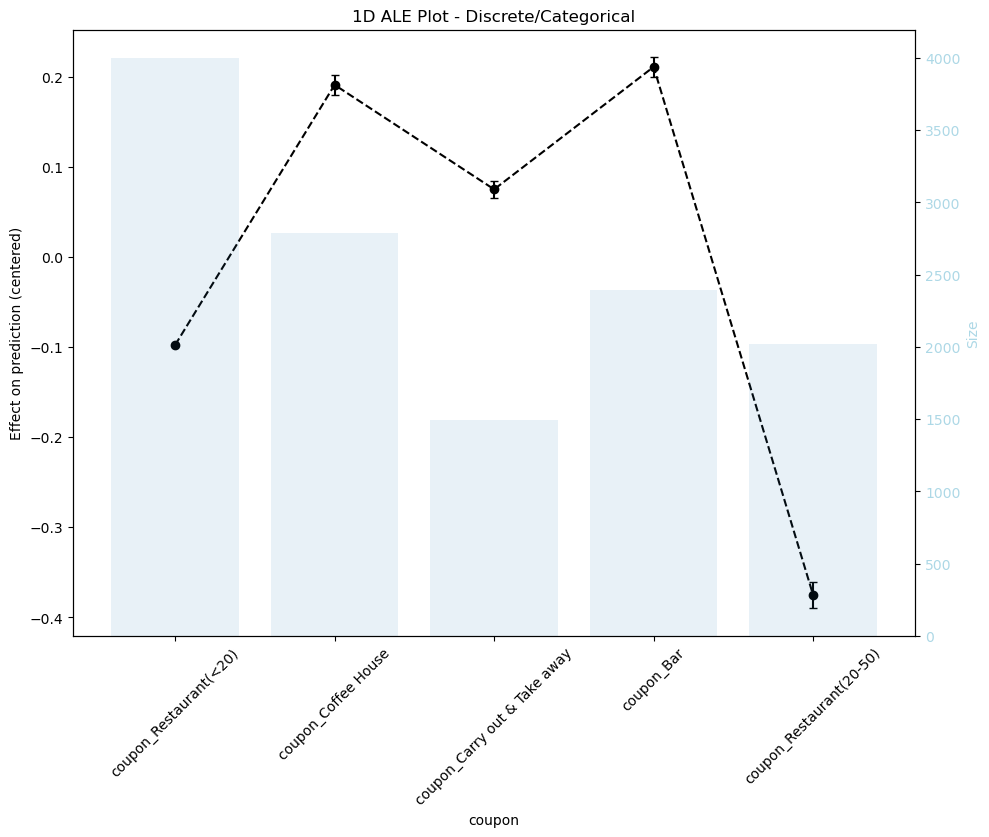

PyALE._ALE_generic:INFO: categorical feature detected.


expiration


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


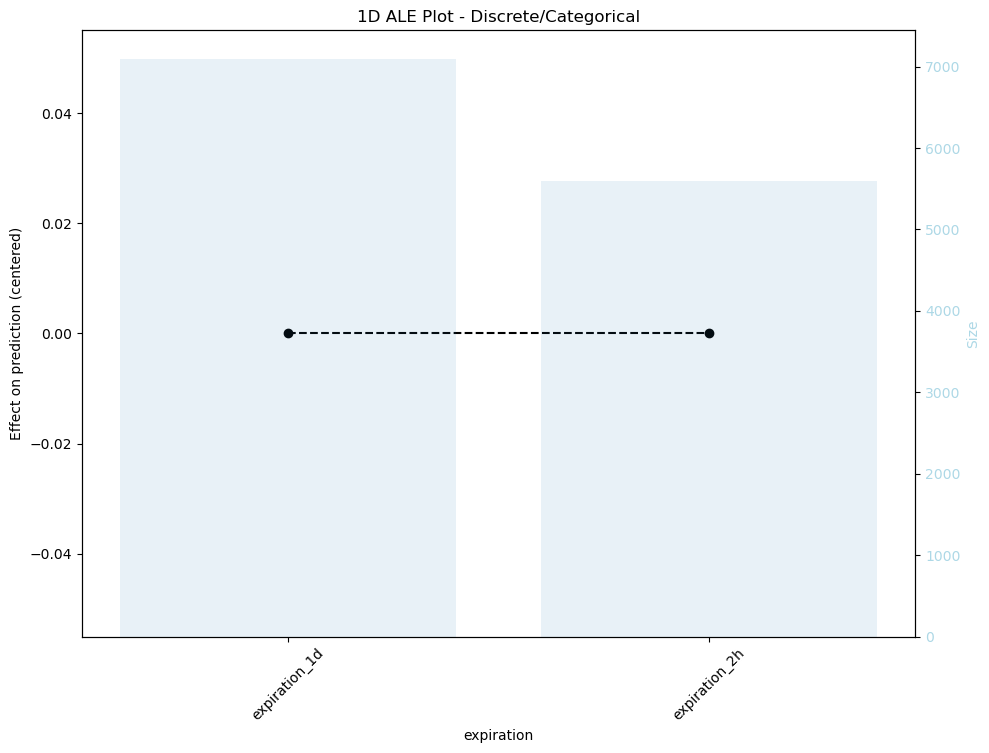

PyALE._ALE_generic:INFO: categorical feature detected.


gender


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


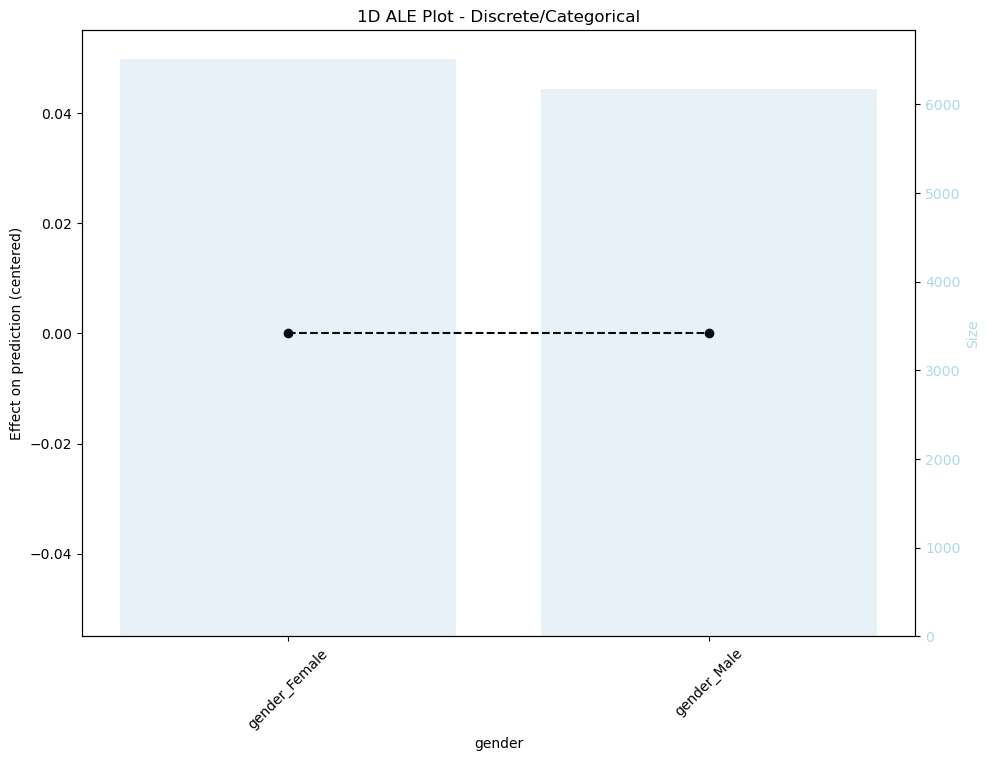

PyALE._ALE_generic:INFO: categorical feature detected.


age


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


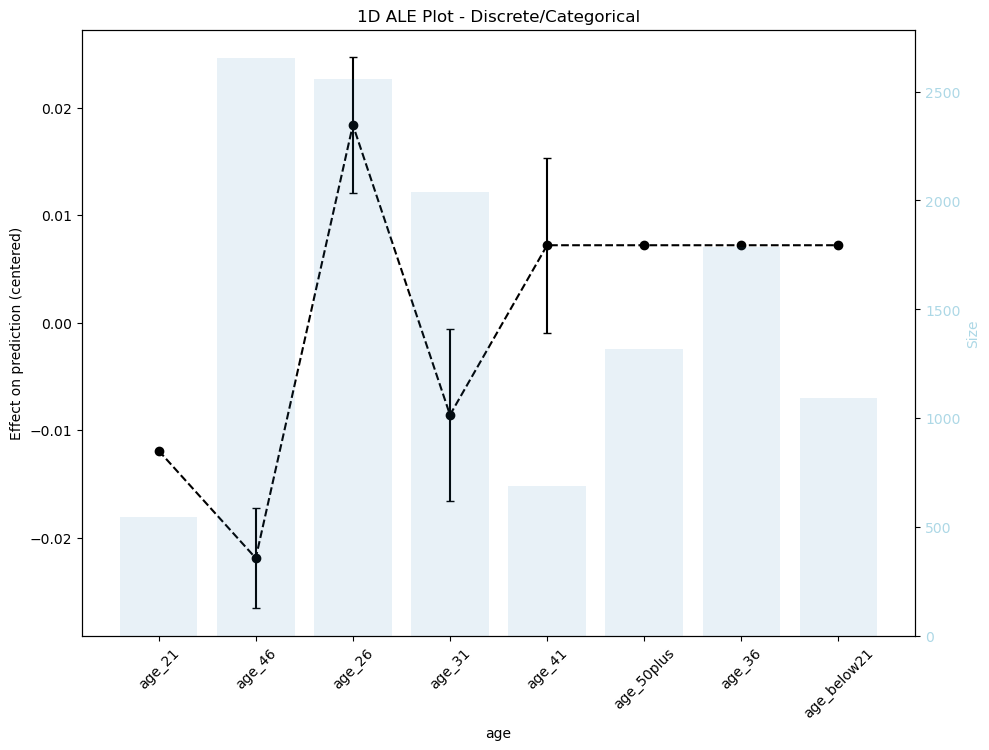

PyALE._ALE_generic:INFO: categorical feature detected.


maritalStatus


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


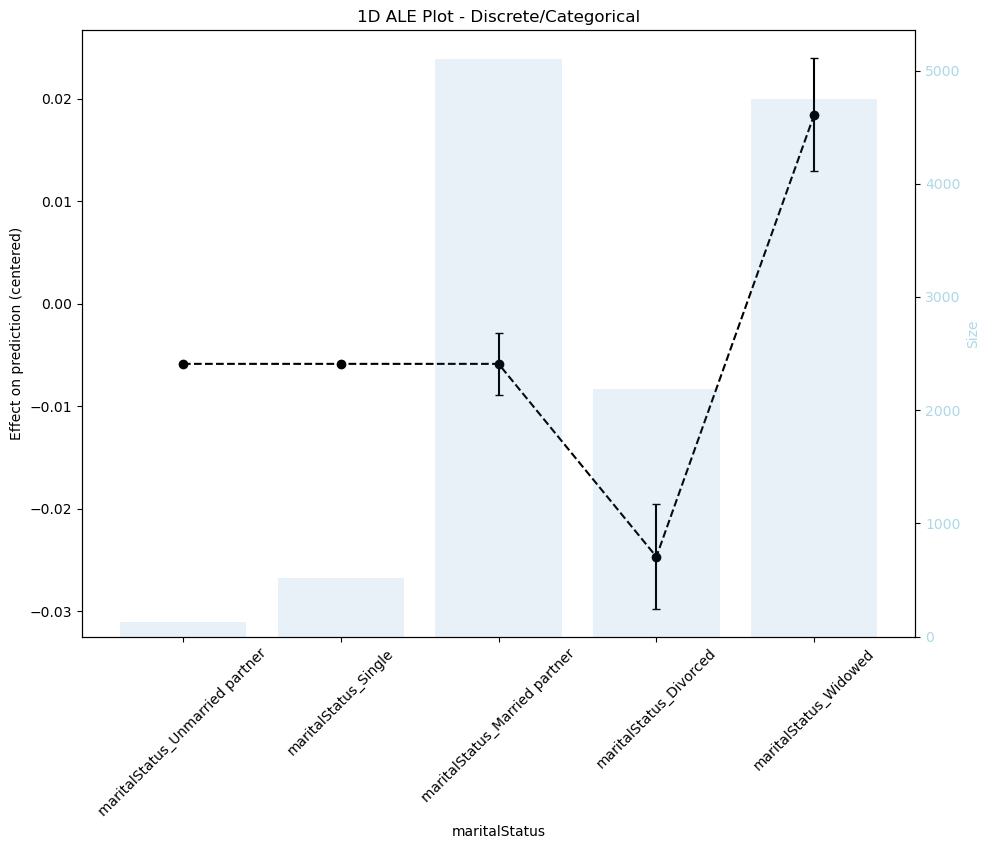

PyALE._ALE_generic:INFO: categorical feature detected.


has_children


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


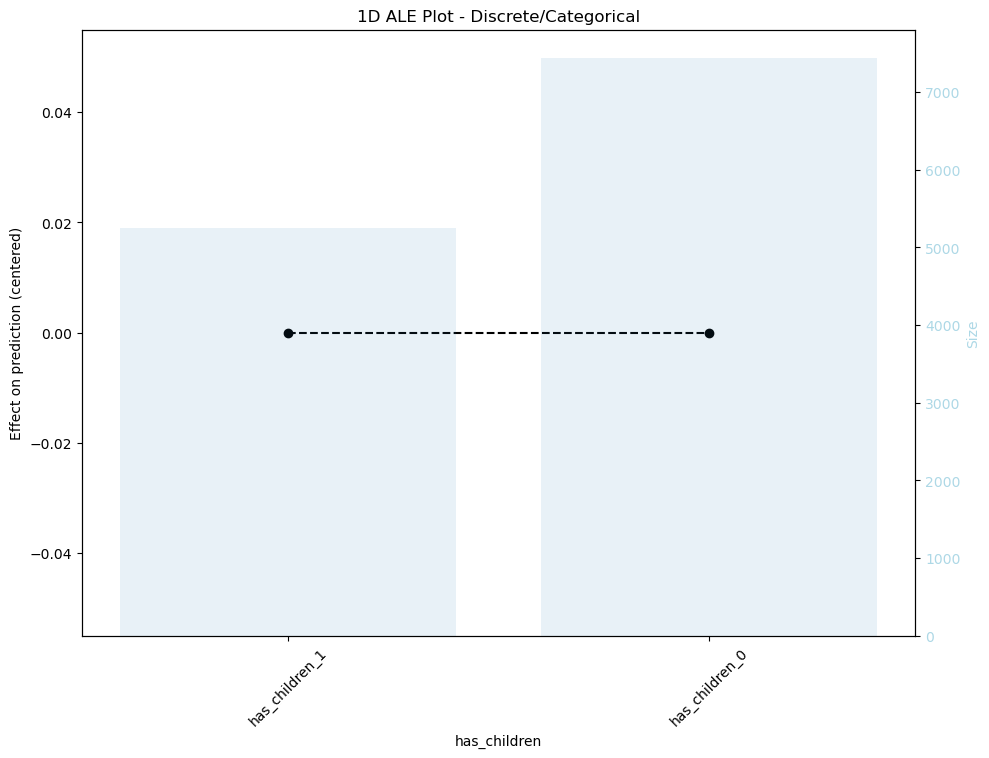

PyALE._ALE_generic:INFO: categorical feature detected.


education


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


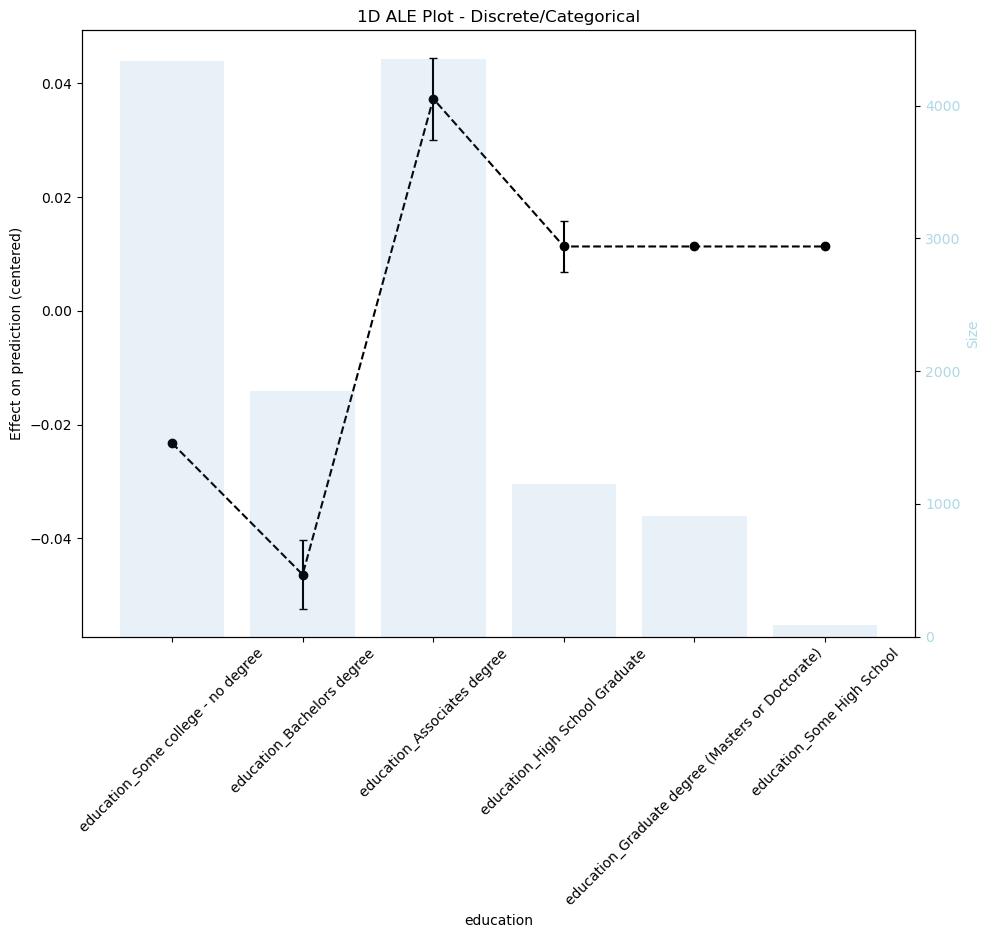

PyALE._ALE_generic:INFO: categorical feature detected.


occupation


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


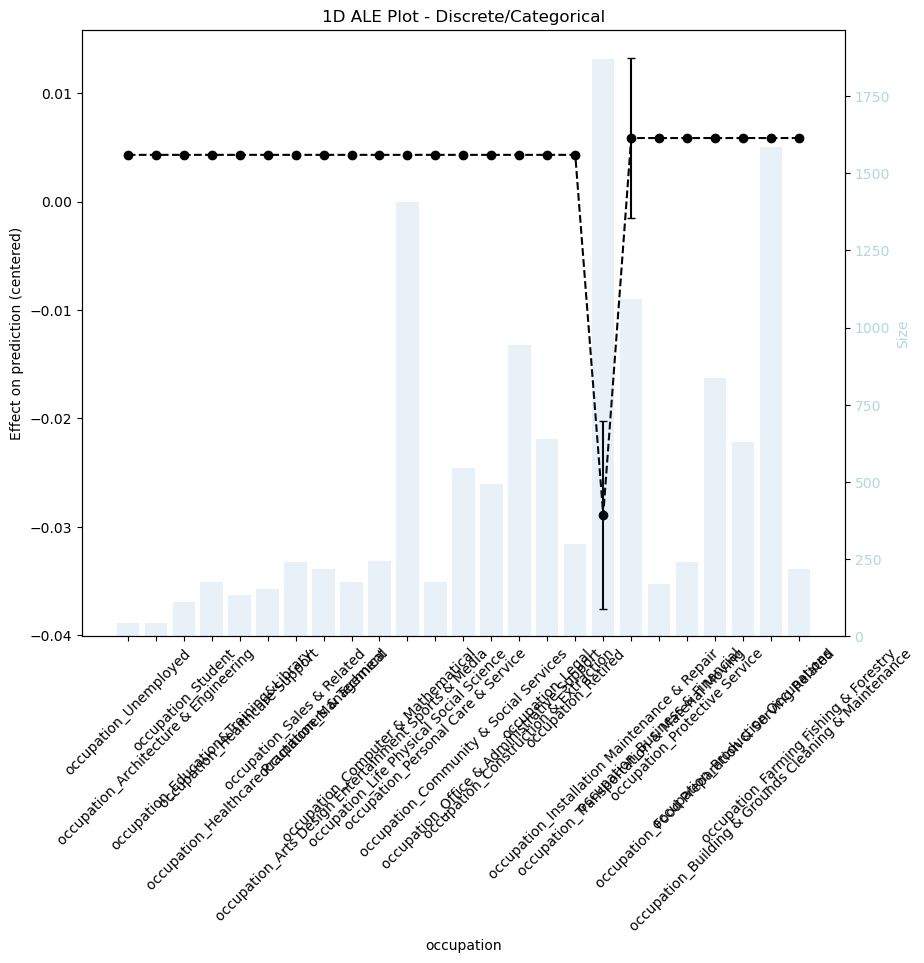

PyALE._ALE_generic:INFO: categorical feature detected.


income


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


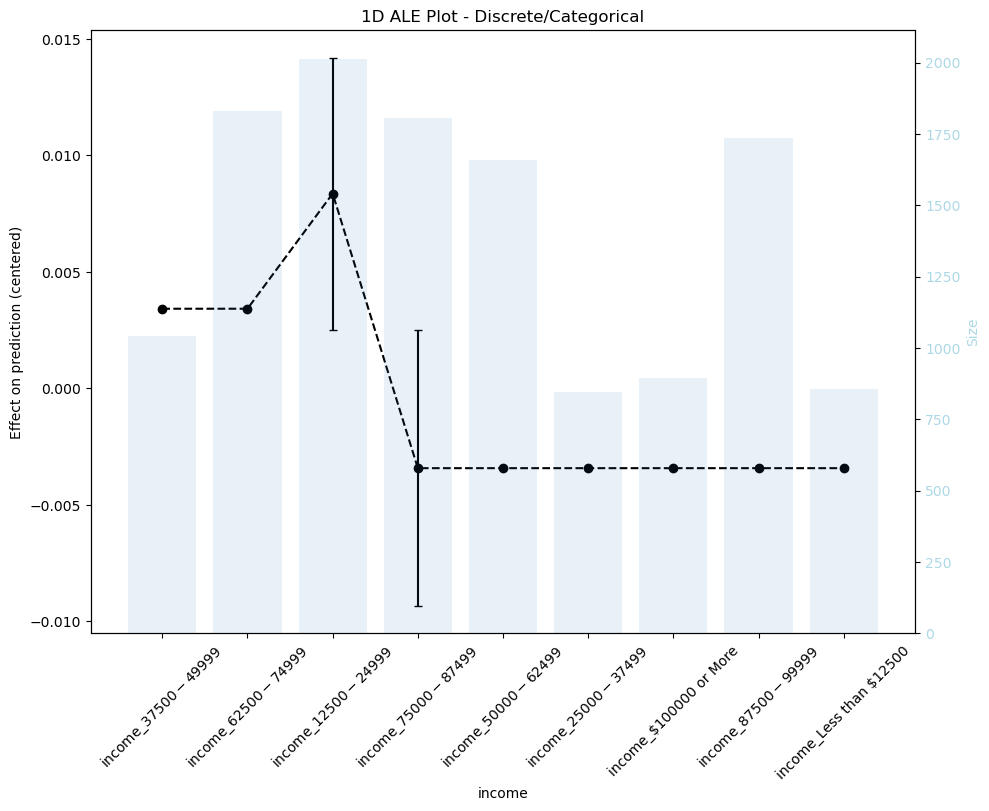

PyALE._ALE_generic:INFO: categorical feature detected.


car


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


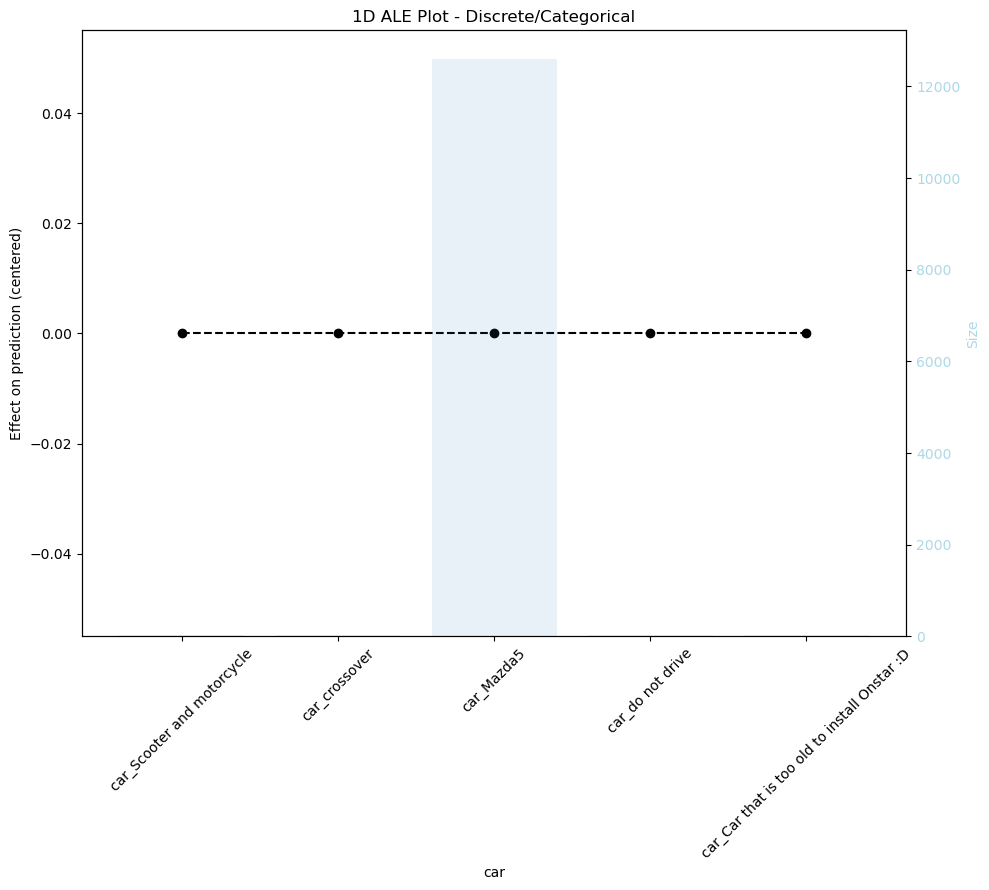

PyALE._ALE_generic:INFO: categorical feature detected.


Bar


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


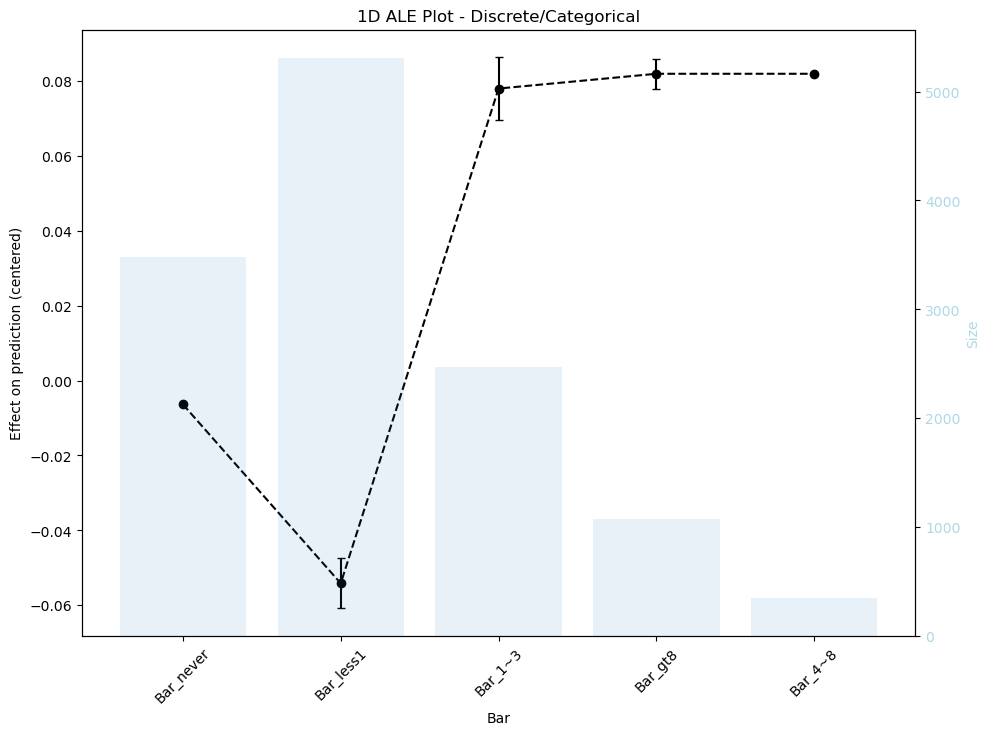

PyALE._ALE_generic:INFO: categorical feature detected.


CoffeeHouse


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


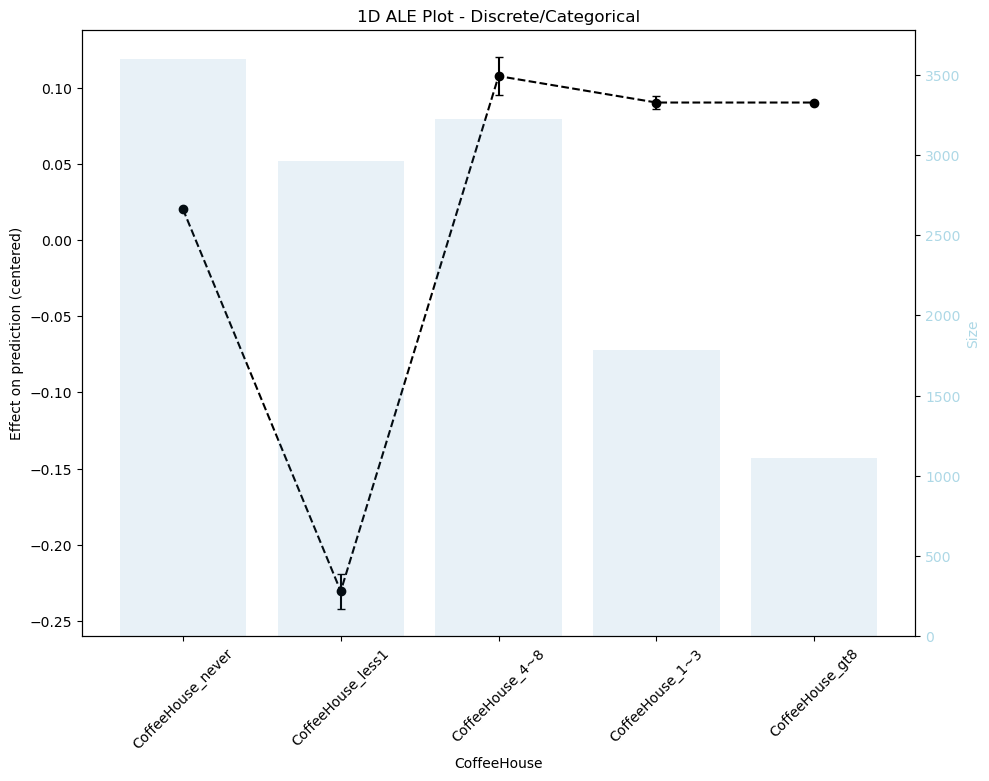

PyALE._ALE_generic:INFO: categorical feature detected.


CarryAway


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


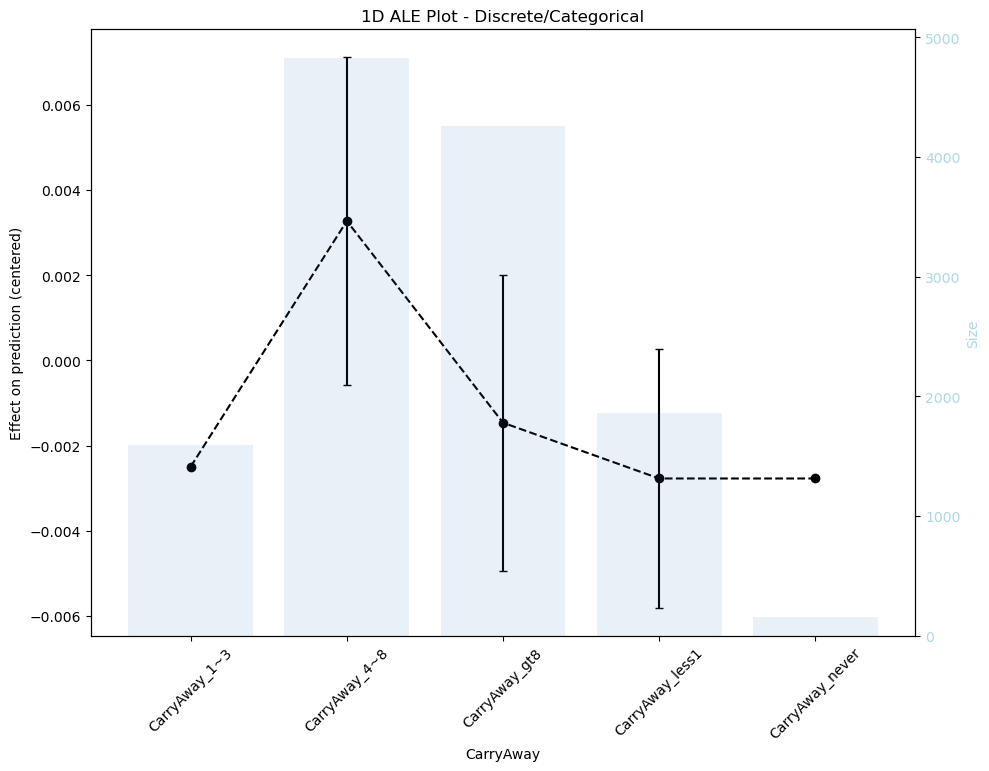

PyALE._ALE_generic:INFO: categorical feature detected.


RestaurantLessThan20


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


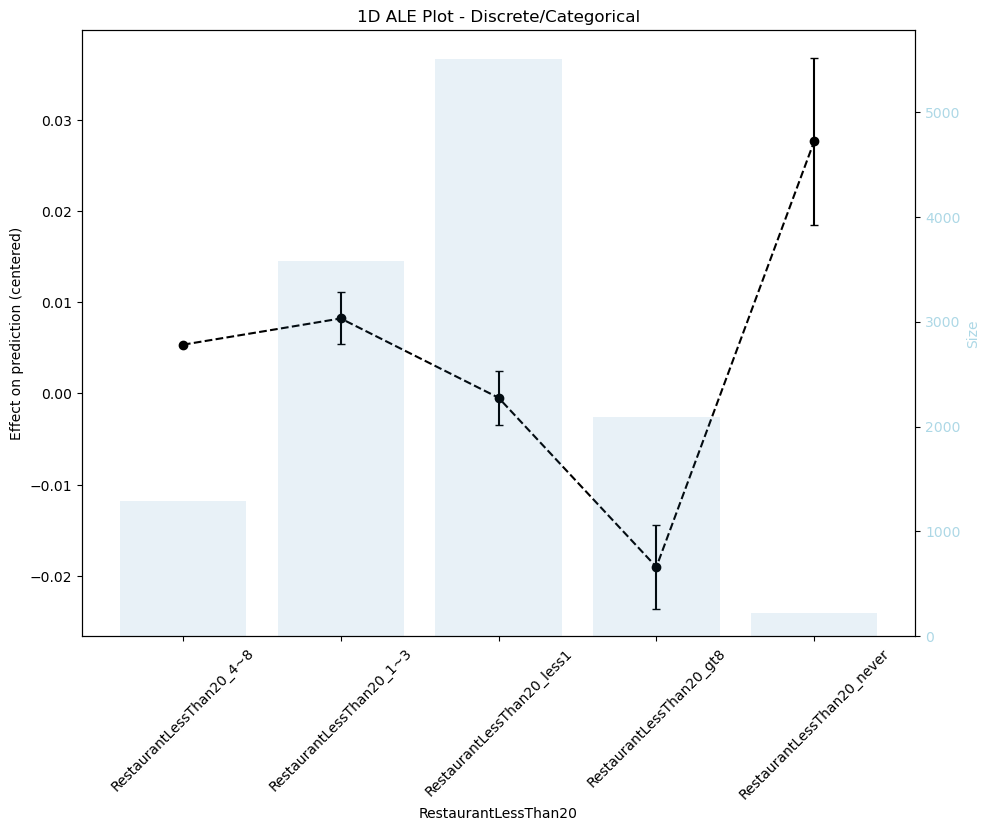

PyALE._ALE_generic:INFO: categorical feature detected.


Restaurant20To50


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


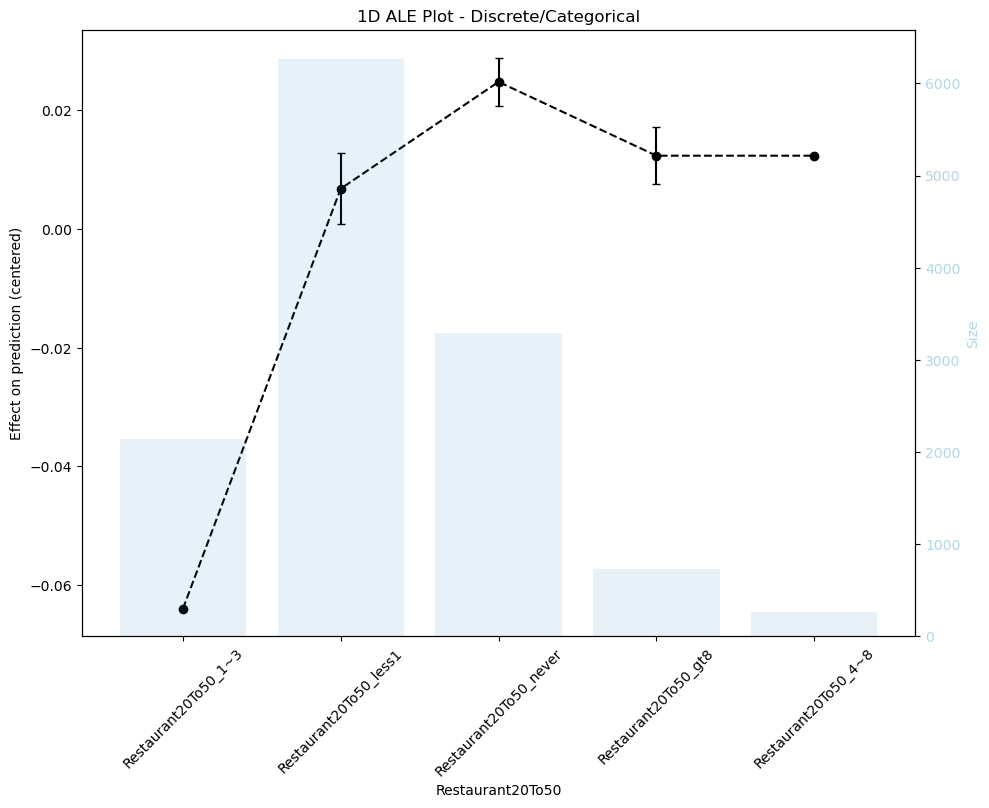

PyALE._ALE_generic:INFO: categorical feature detected.


toCoupon_GEQ15min


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


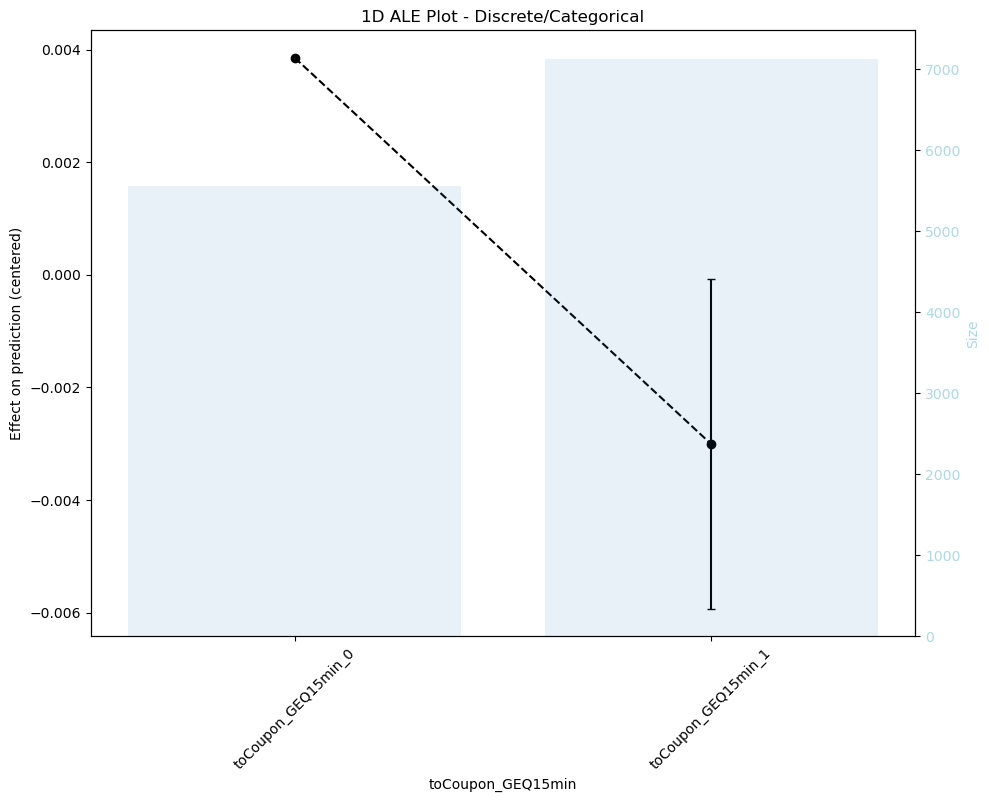

PyALE._ALE_generic:INFO: categorical feature detected.


toCoupon_GEQ25min


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


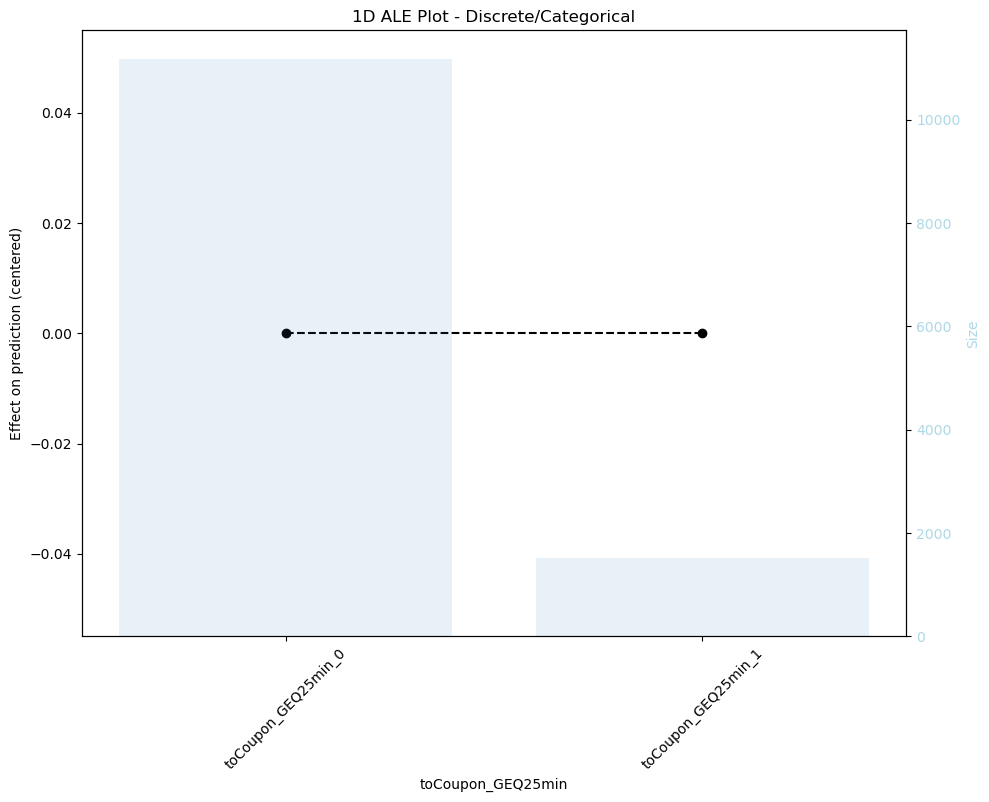

PyALE._ALE_generic:INFO: categorical feature detected.


direction_same


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


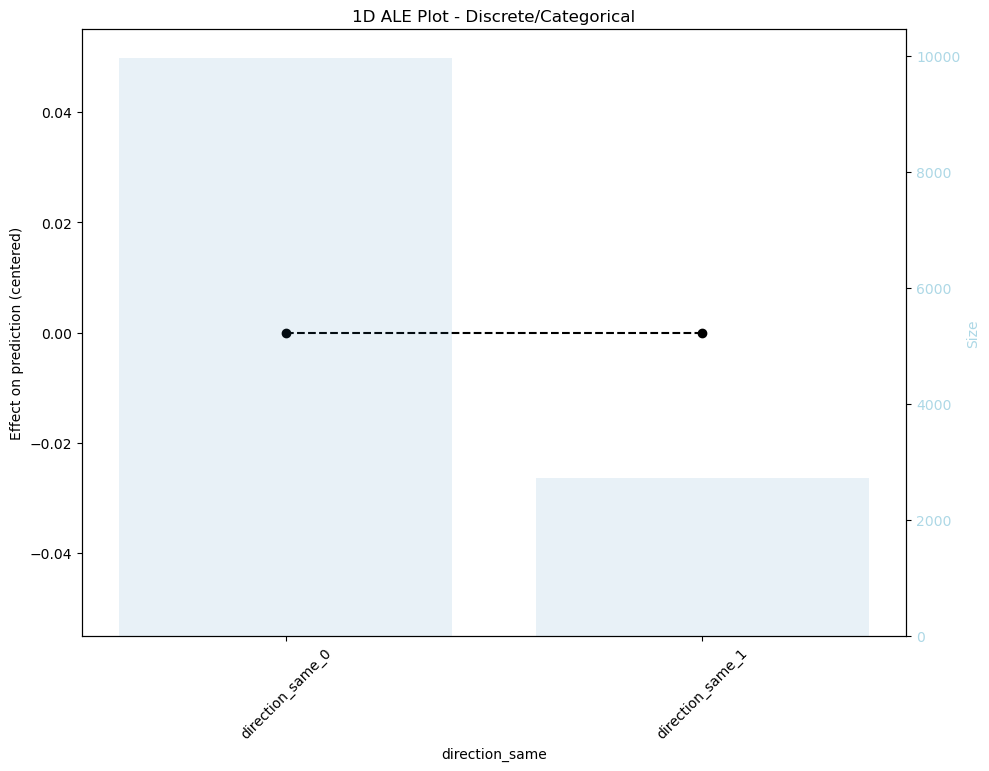

PyALE._ALE_generic:INFO: categorical feature detected.


direction_opp


<ipython-input-23-7cdd70b3a824>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df[col].unique(), rotation=45)


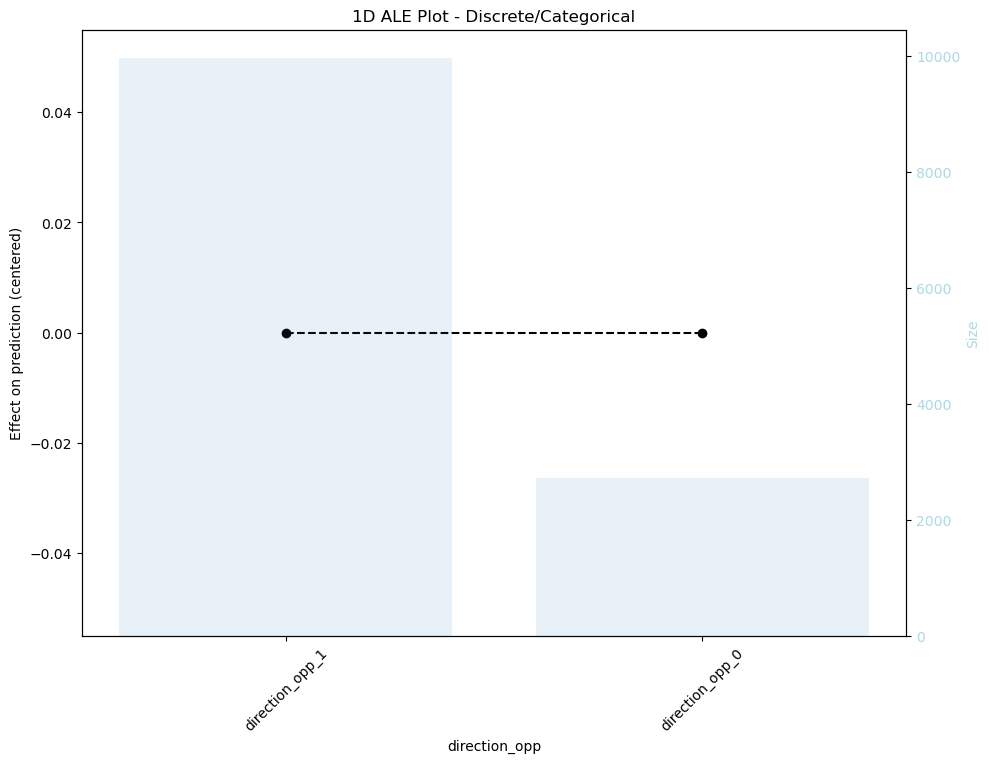

In [23]:
col_list = list(df.columns) # features to do ALEPlot
col_list.remove('toCoupon_GEQ5min') # only have one value - ALEPlot wont work
col_list.remove('Y') # label

for col in col_list:
    print(col)
    fig, ax = plt.subplots(figsize=(10, 7))
    hyeni_pyale(df,df_ohe,xgb,col,fig=fig,ax=ax)
    ax.set_xticklabels(df[col].unique(), rotation=45)
    plt.show()

PyALE._ALE_generic:INFO: categorical feature detected.


destination


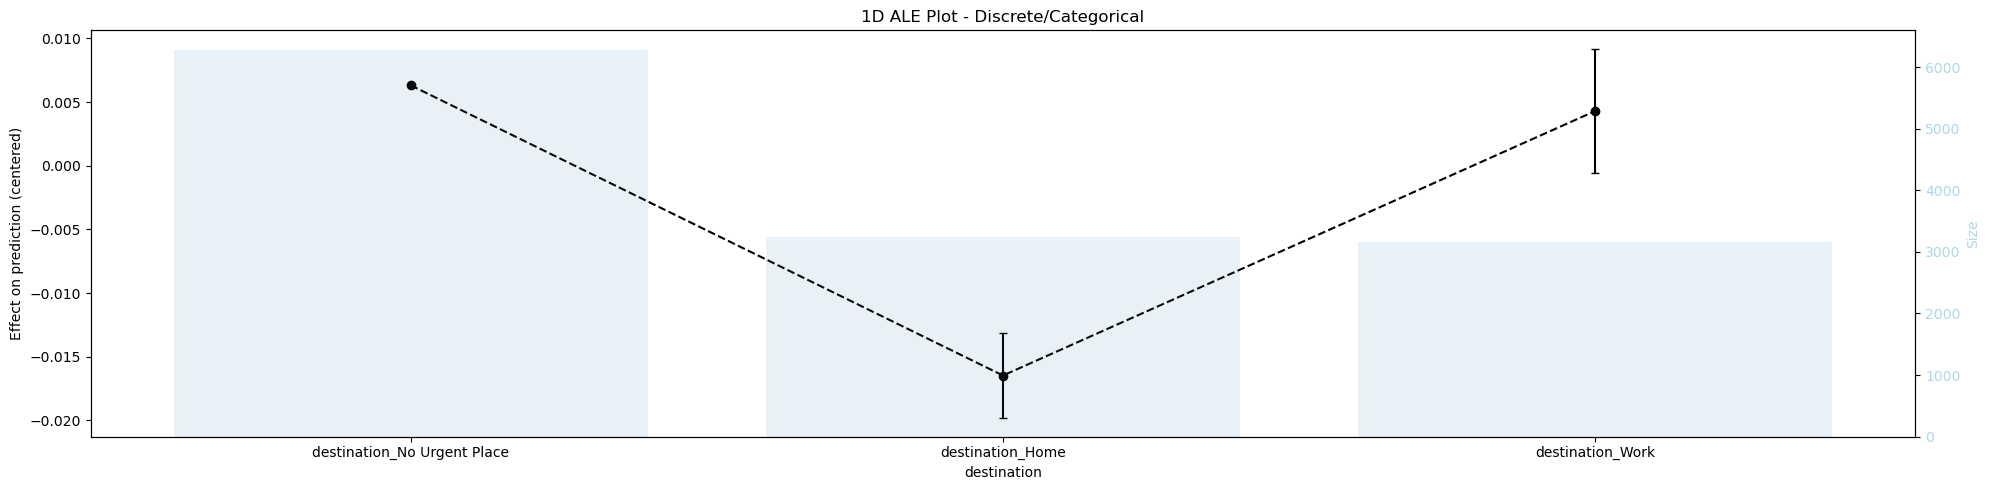

PyALE._ALE_generic:INFO: categorical feature detected.


passanger


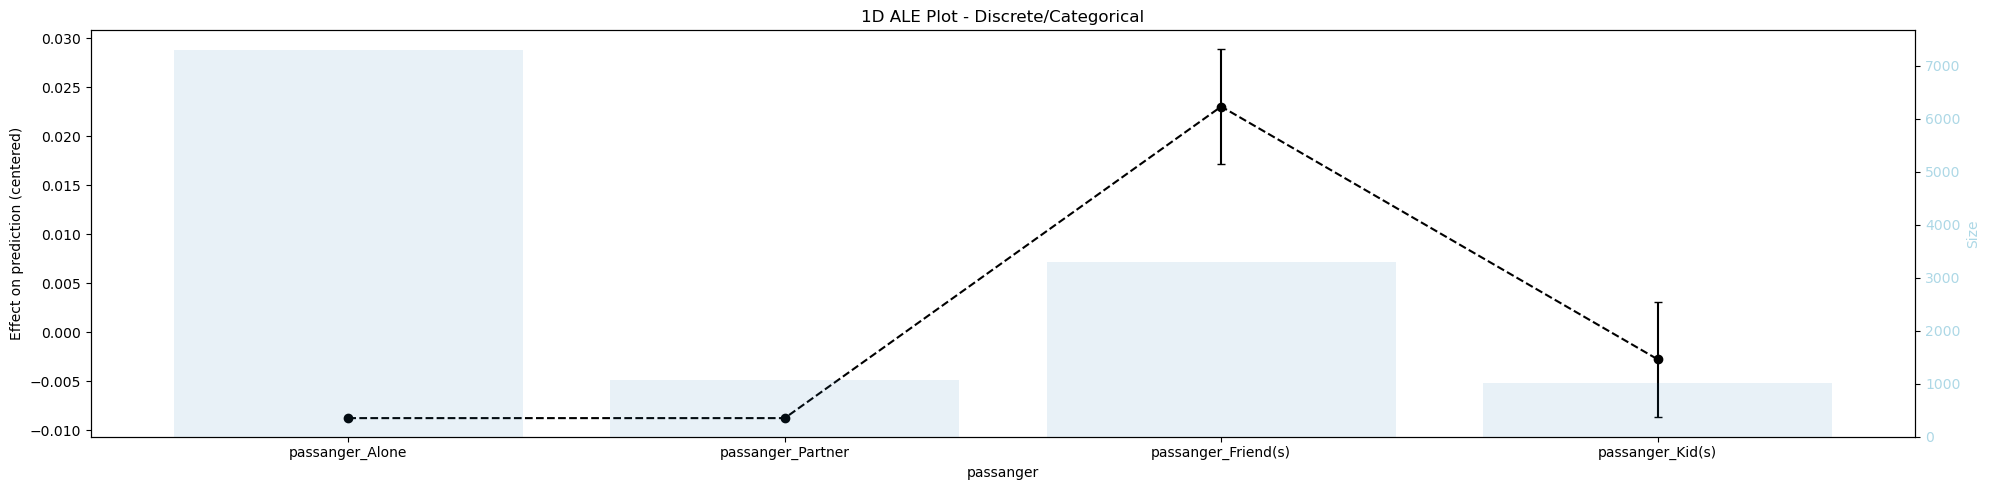

PyALE._ALE_generic:INFO: categorical feature detected.


weather


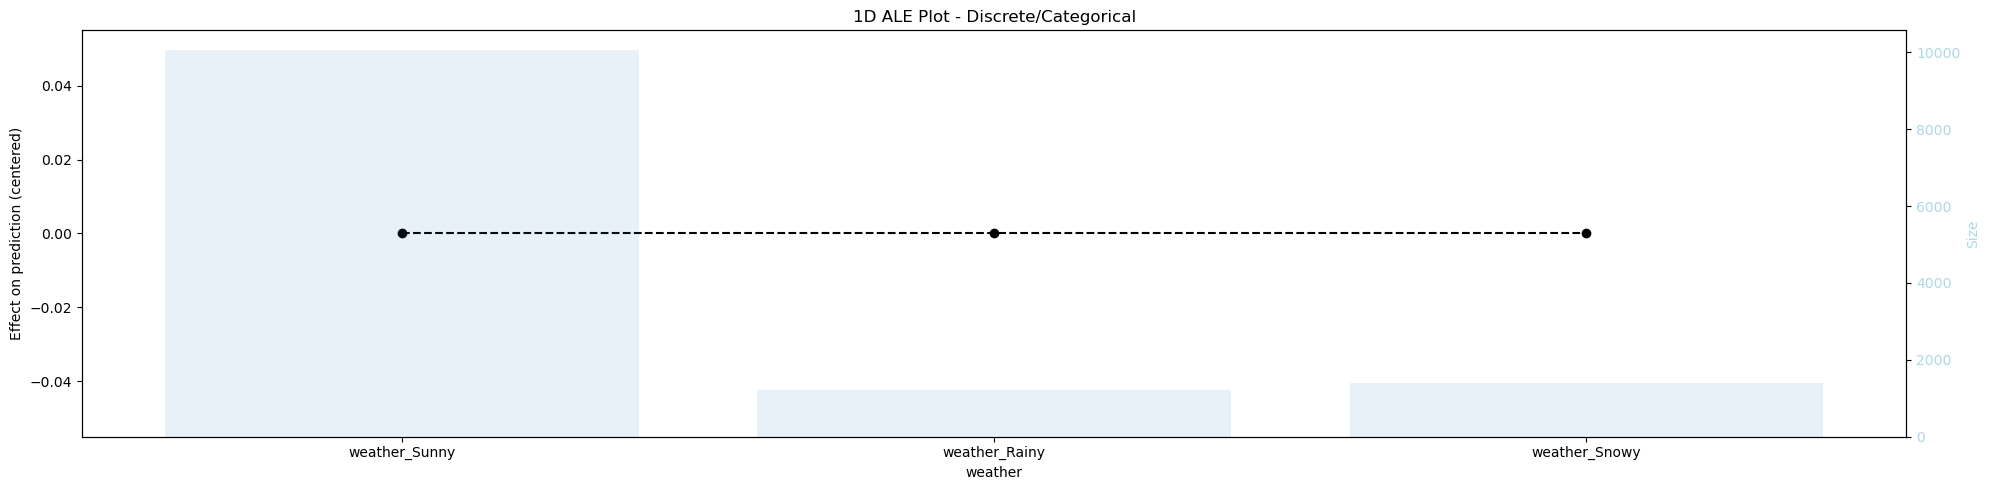

PyALE._ALE_generic:INFO: categorical feature detected.


temperature


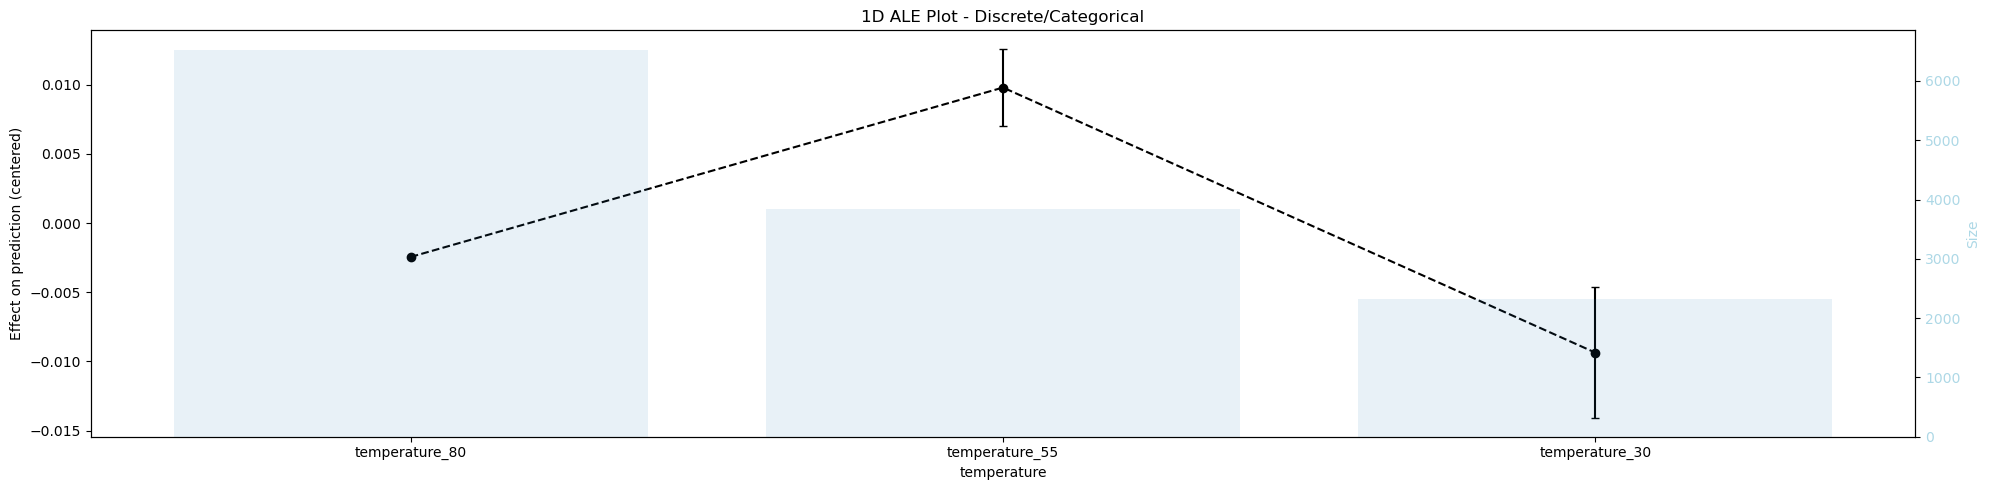

PyALE._ALE_generic:INFO: categorical feature detected.


time


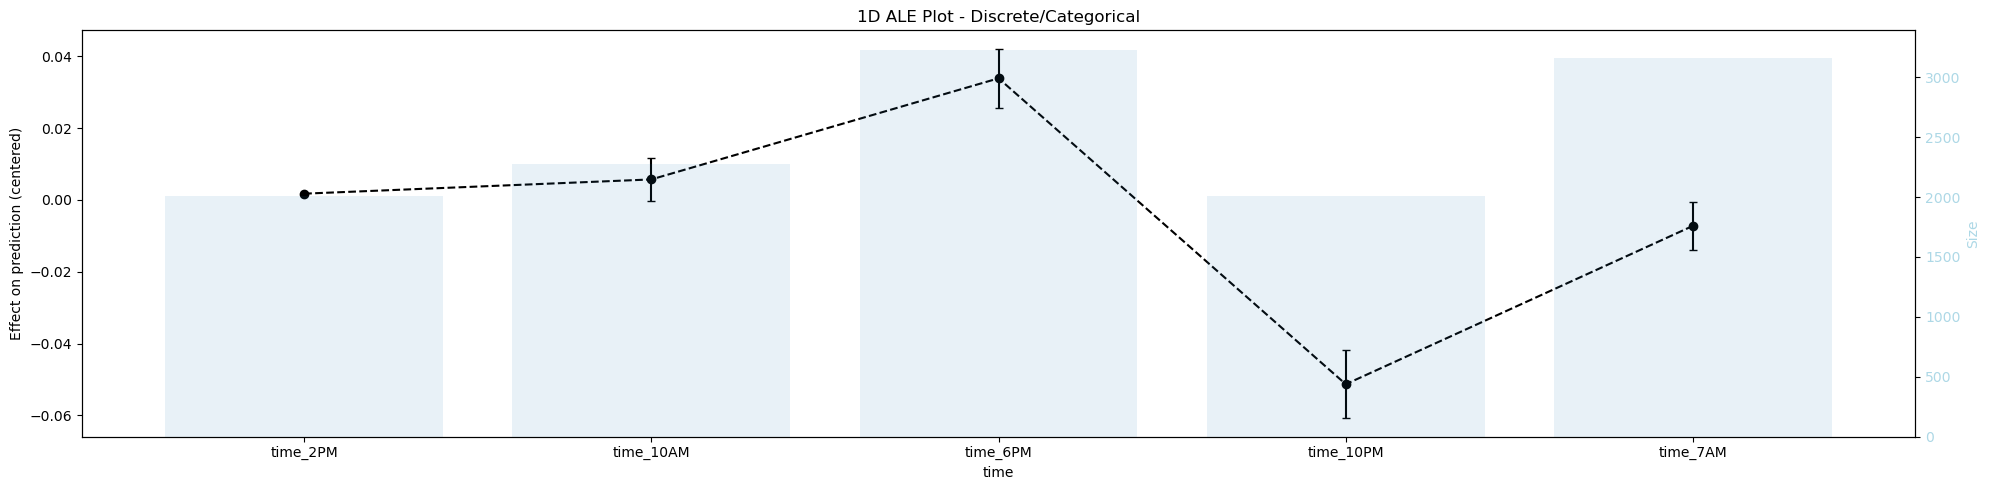

PyALE._ALE_generic:INFO: categorical feature detected.


coupon


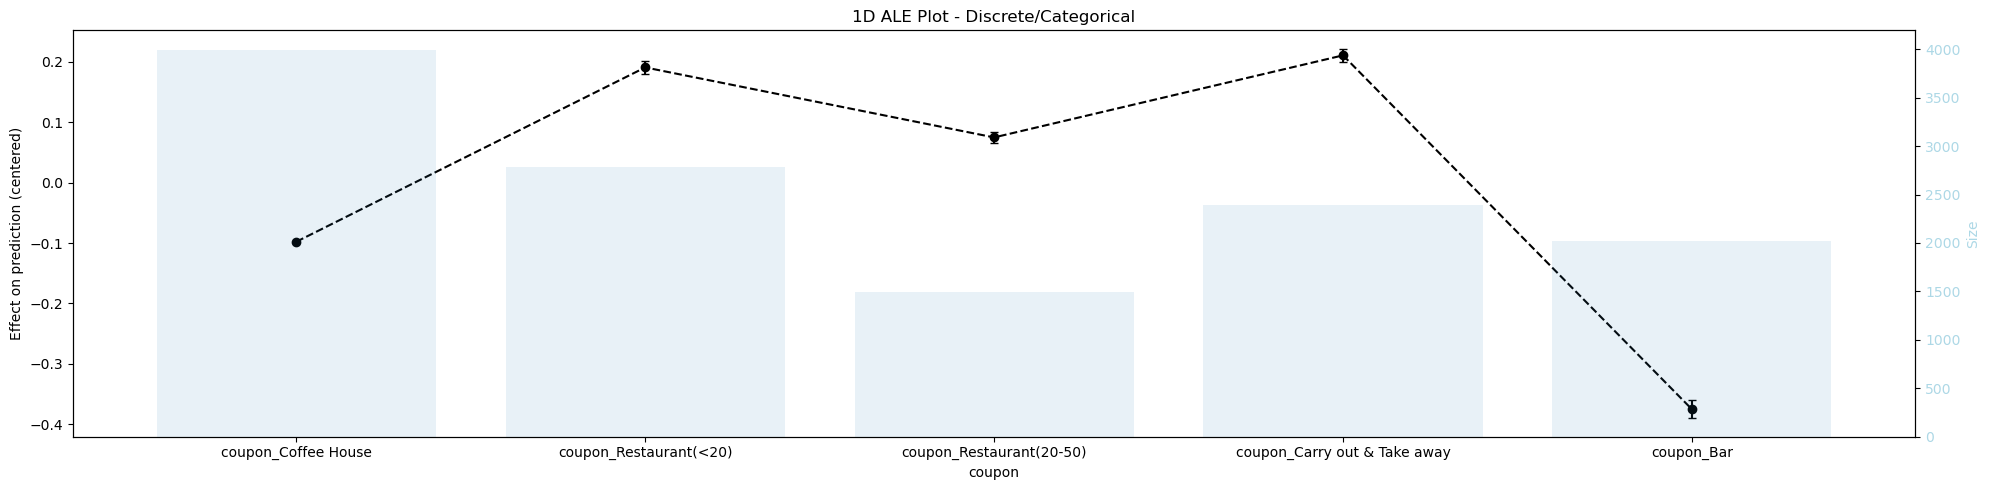

PyALE._ALE_generic:INFO: categorical feature detected.


expiration


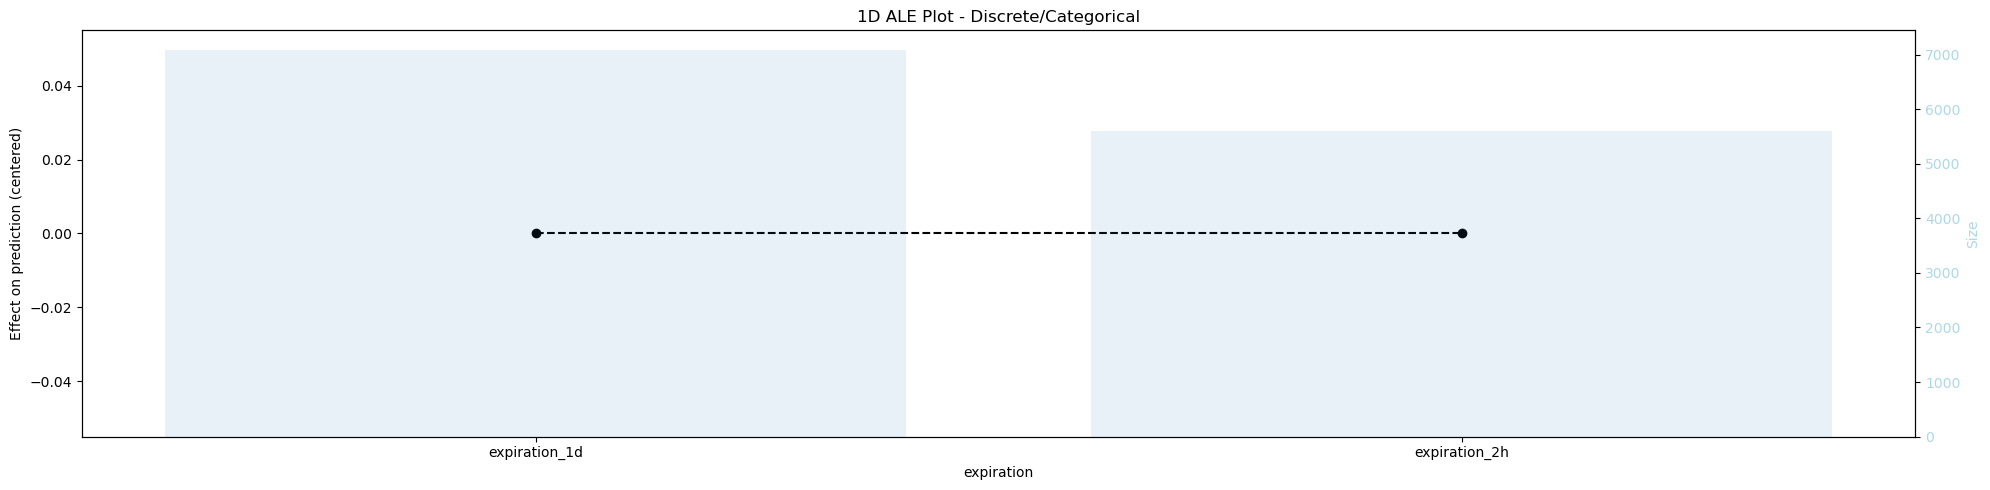

PyALE._ALE_generic:INFO: categorical feature detected.


gender


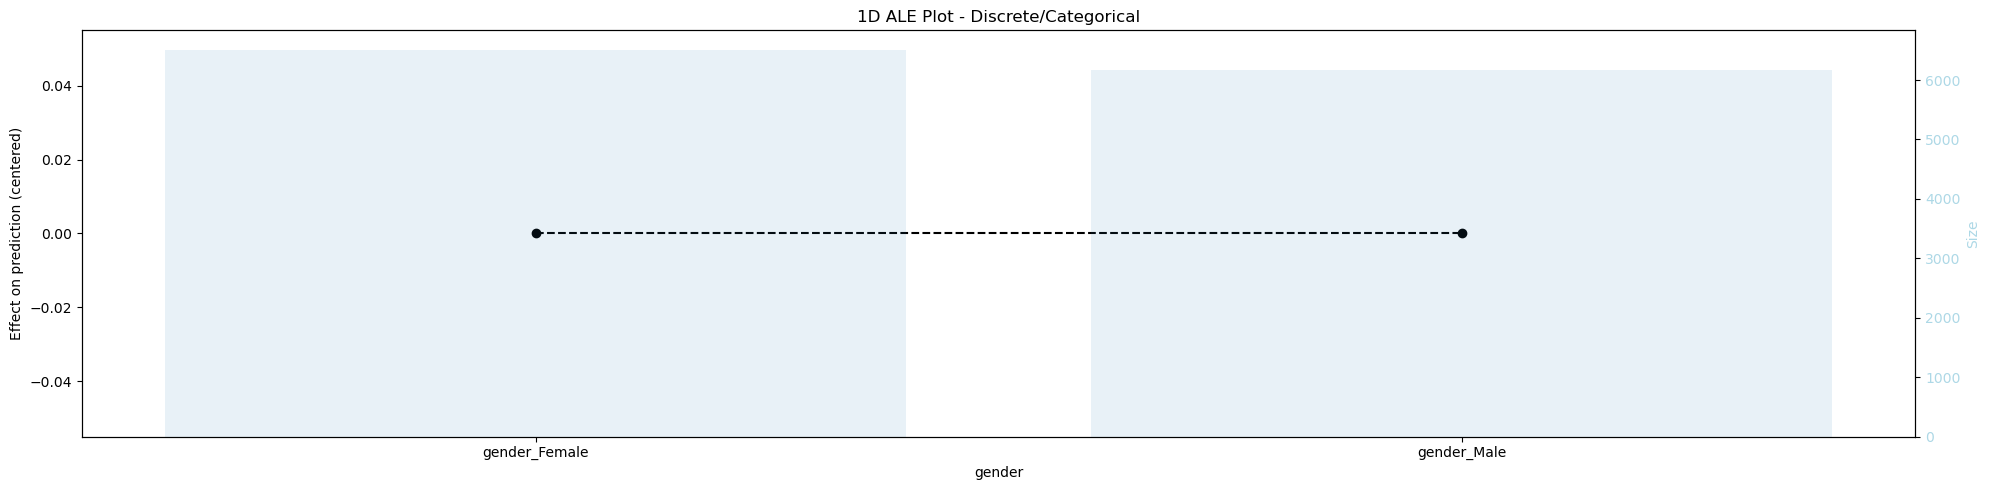

PyALE._ALE_generic:INFO: categorical feature detected.


age


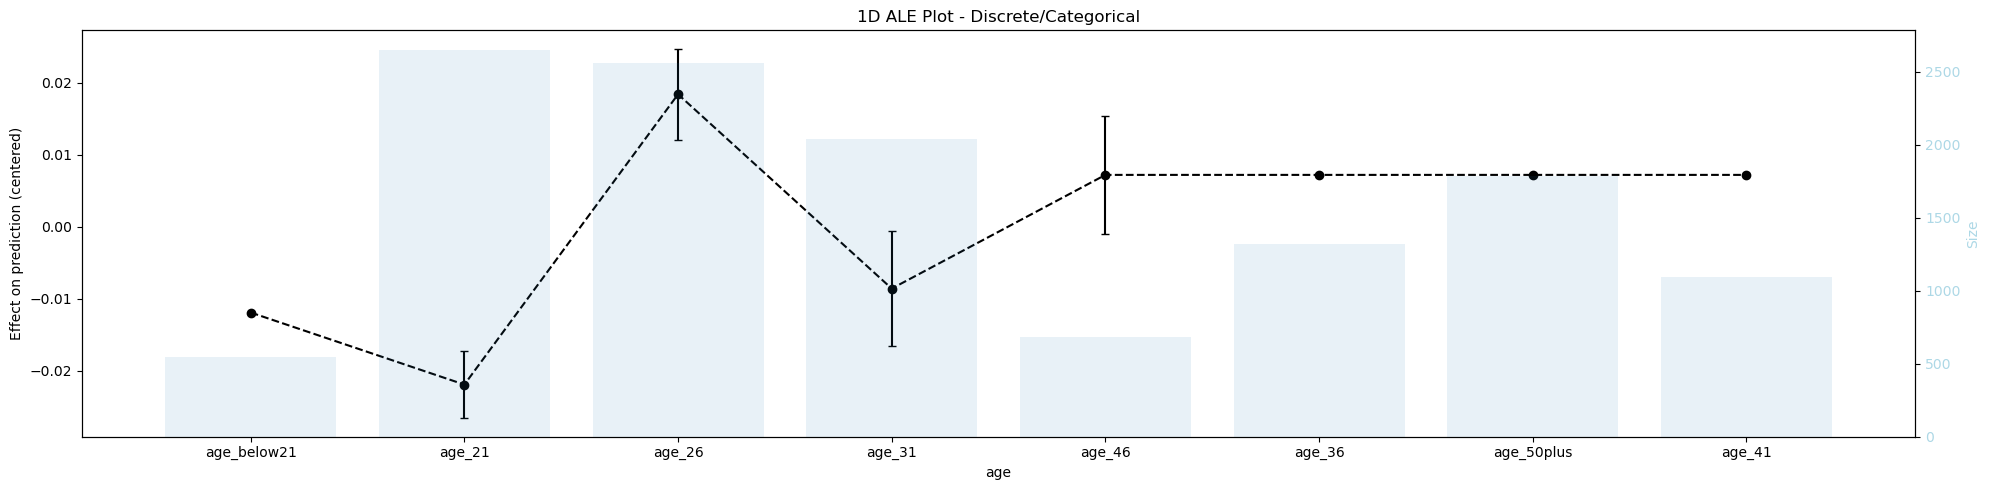

PyALE._ALE_generic:INFO: categorical feature detected.


maritalStatus


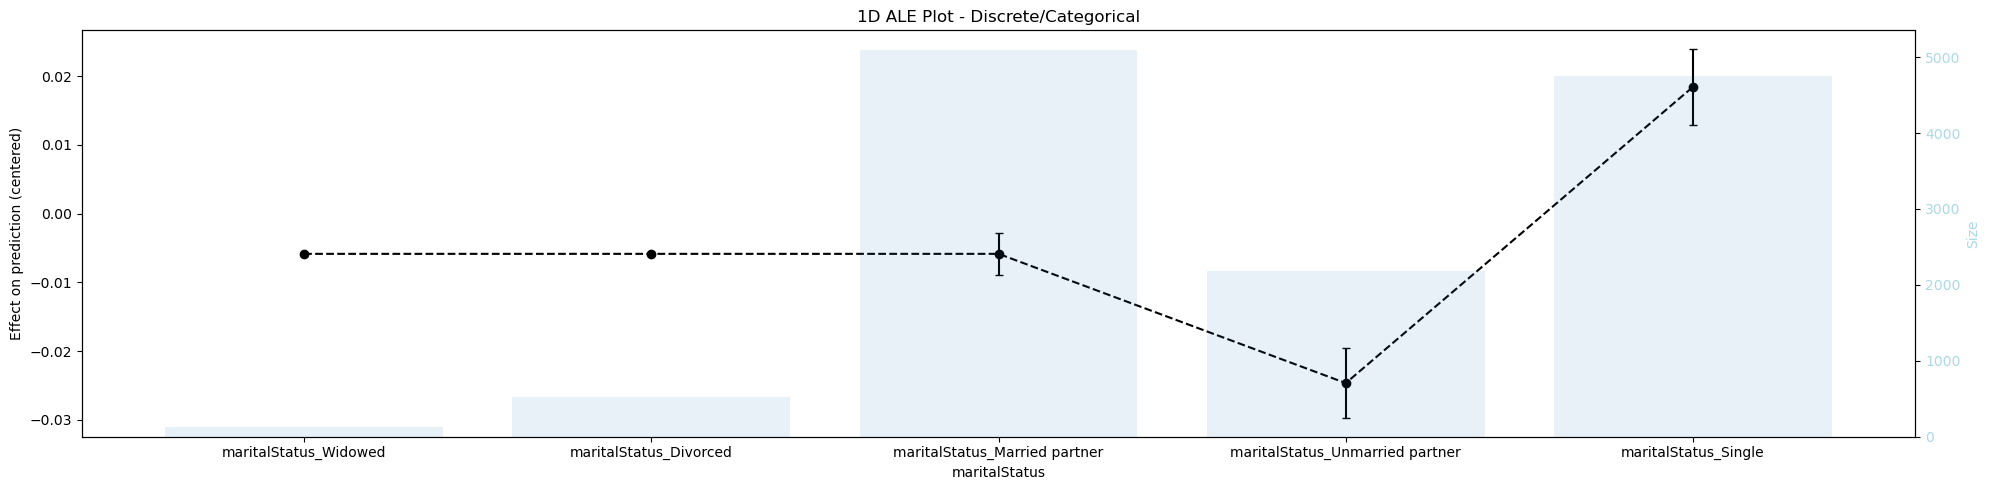

PyALE._ALE_generic:INFO: categorical feature detected.


has_children


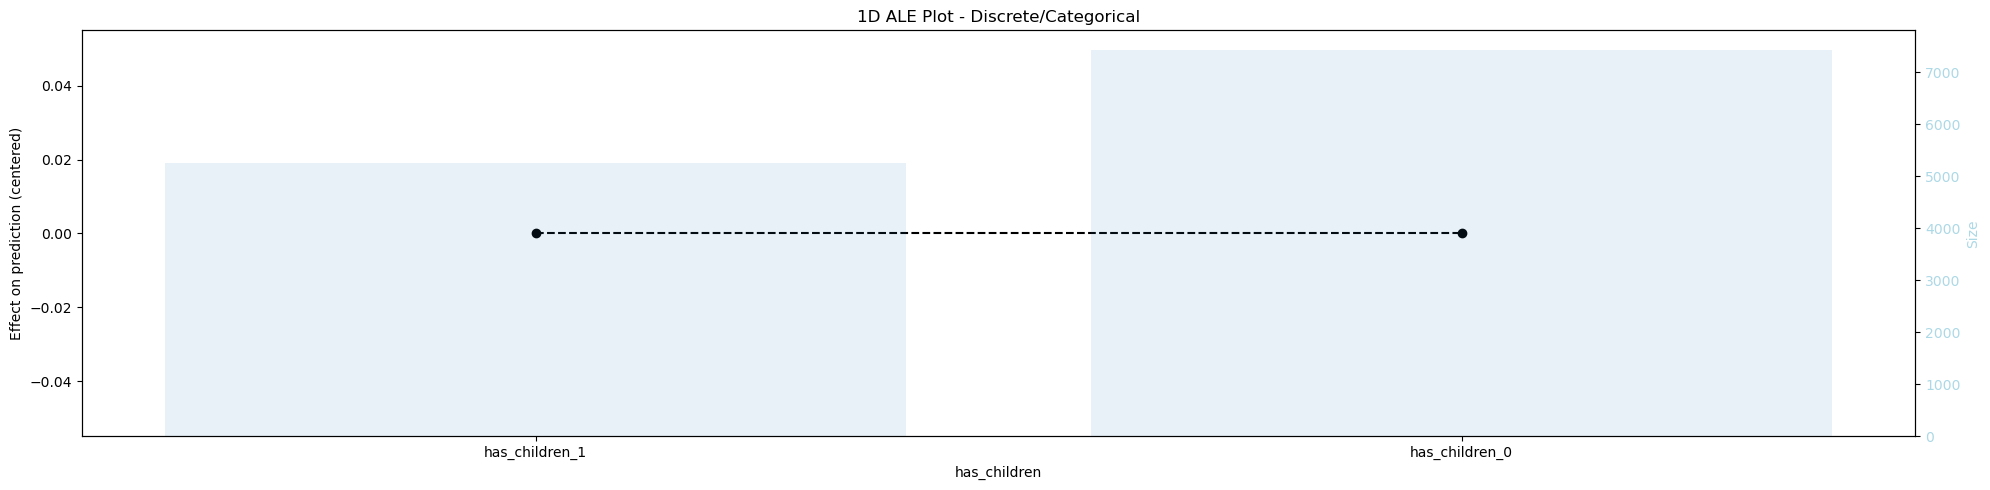

PyALE._ALE_generic:INFO: categorical feature detected.


education


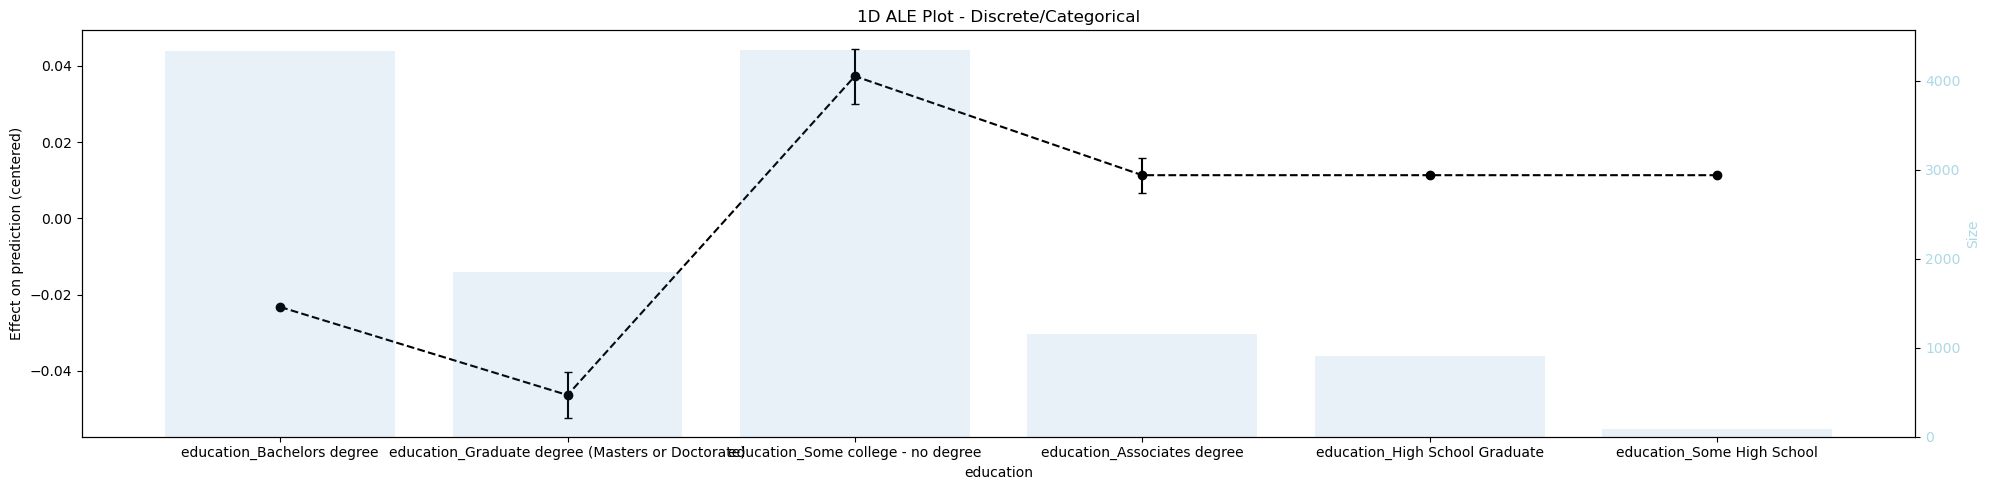

PyALE._ALE_generic:INFO: categorical feature detected.


occupation


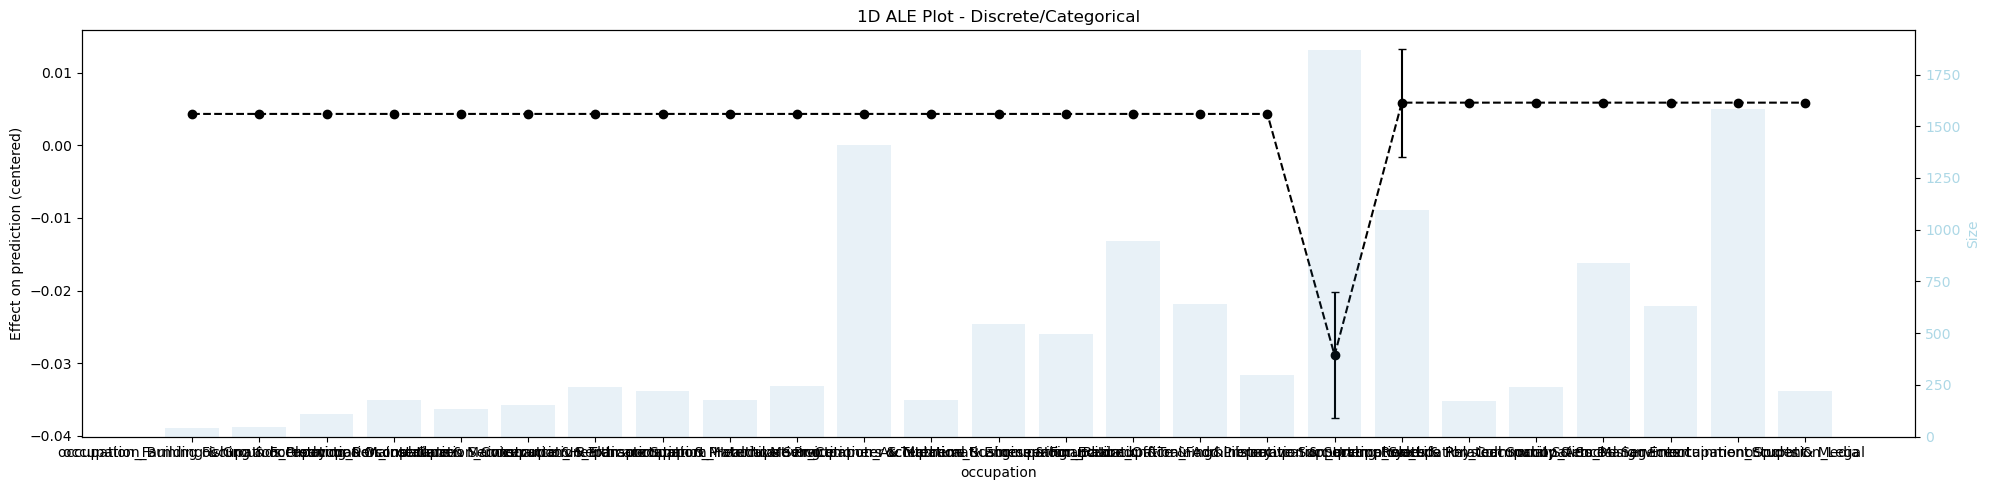

PyALE._ALE_generic:INFO: categorical feature detected.


income


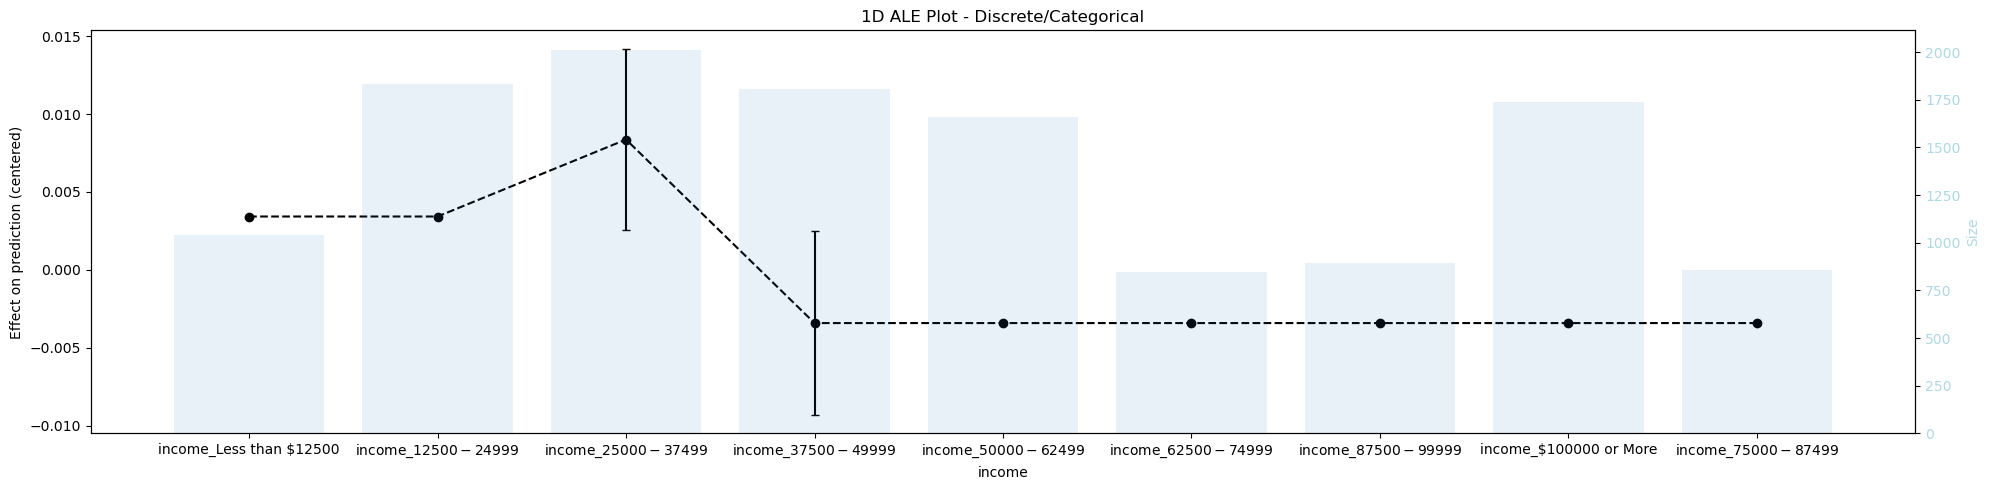

PyALE._ALE_generic:INFO: categorical feature detected.


car


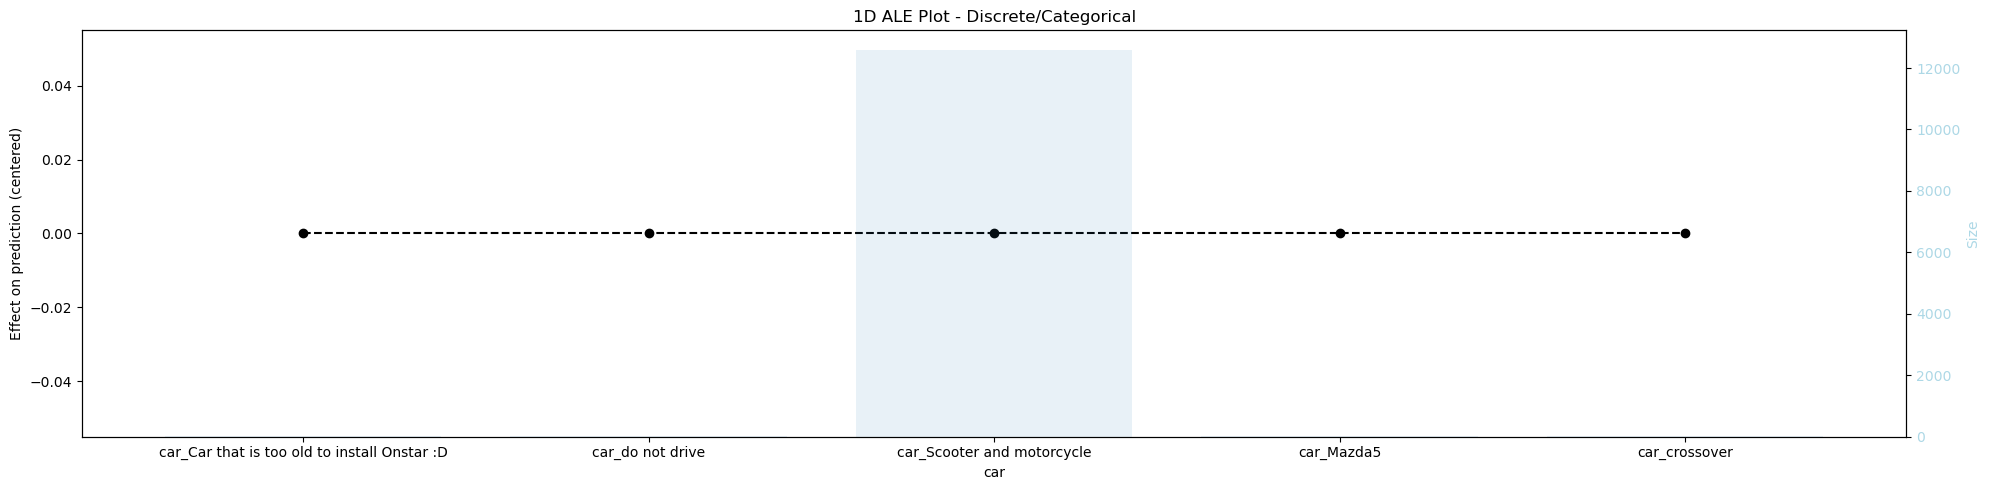

PyALE._ALE_generic:INFO: categorical feature detected.


Bar


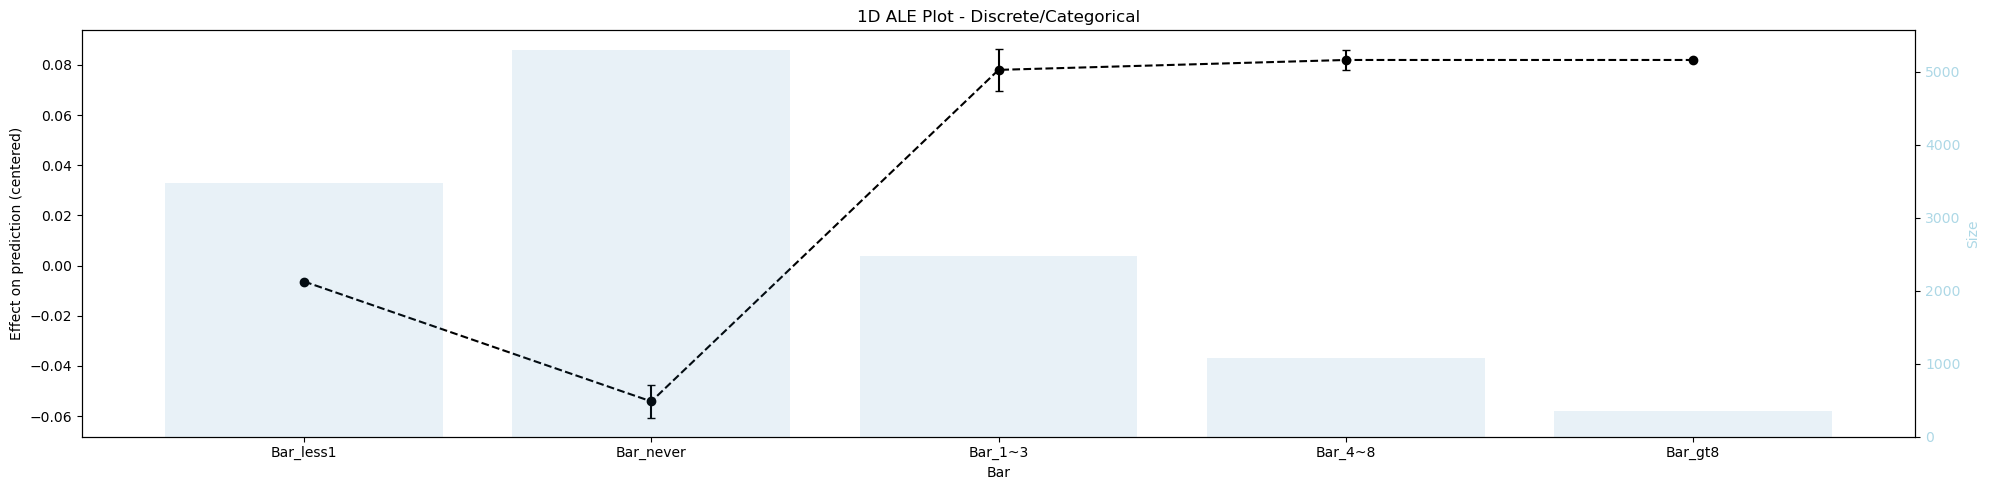

PyALE._ALE_generic:INFO: categorical feature detected.


CoffeeHouse


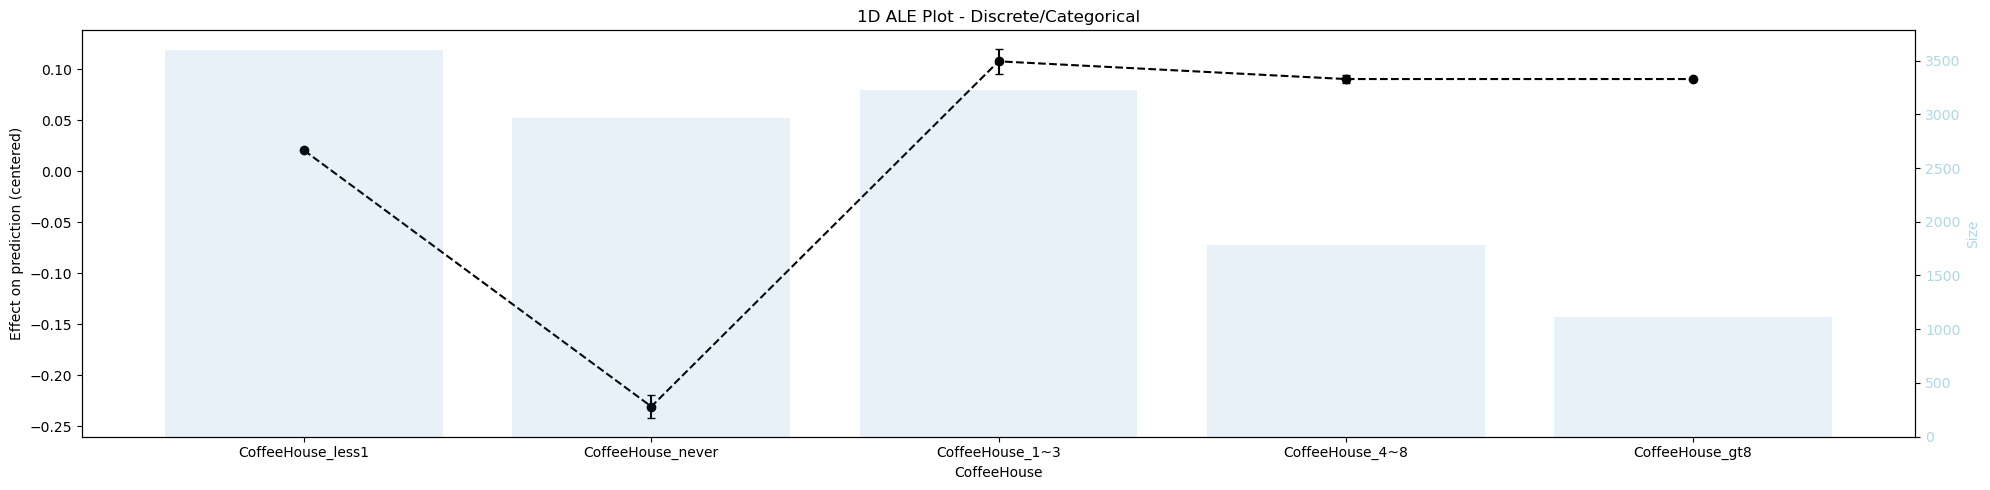

PyALE._ALE_generic:INFO: categorical feature detected.


CarryAway


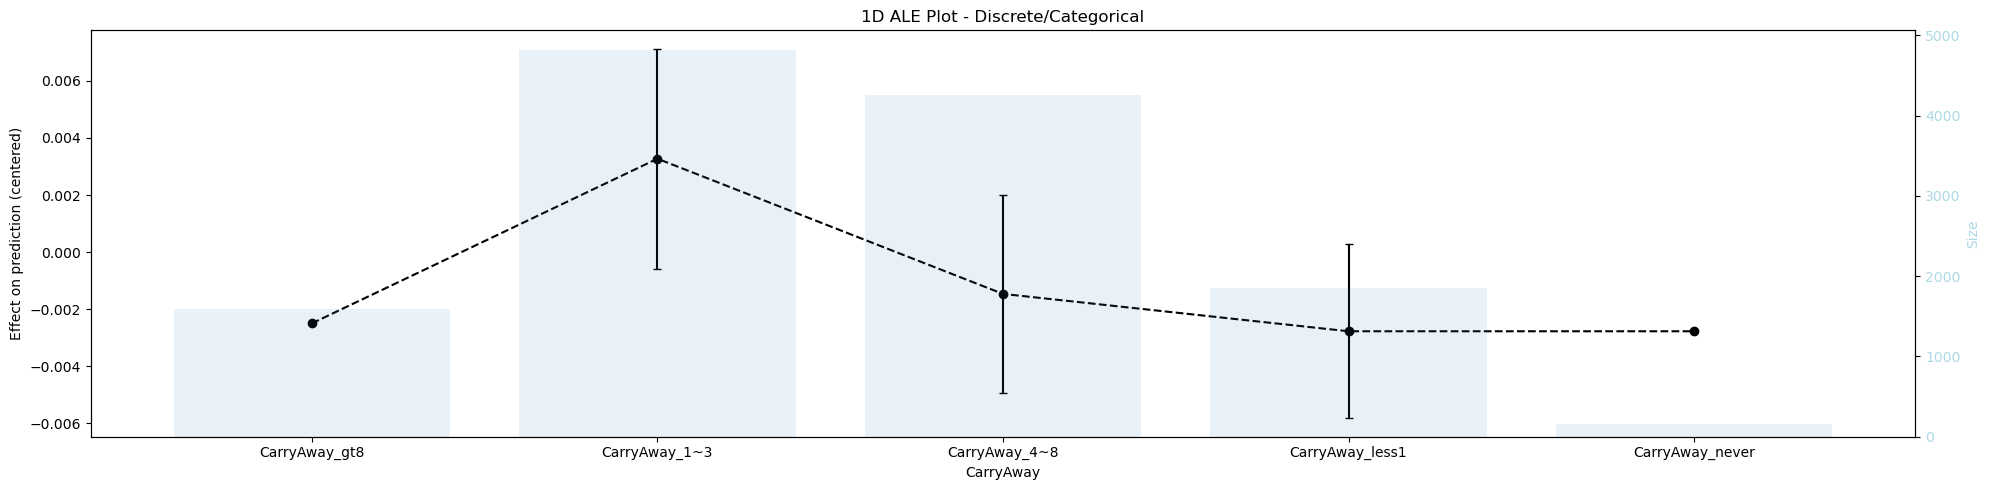

PyALE._ALE_generic:INFO: categorical feature detected.


RestaurantLessThan20


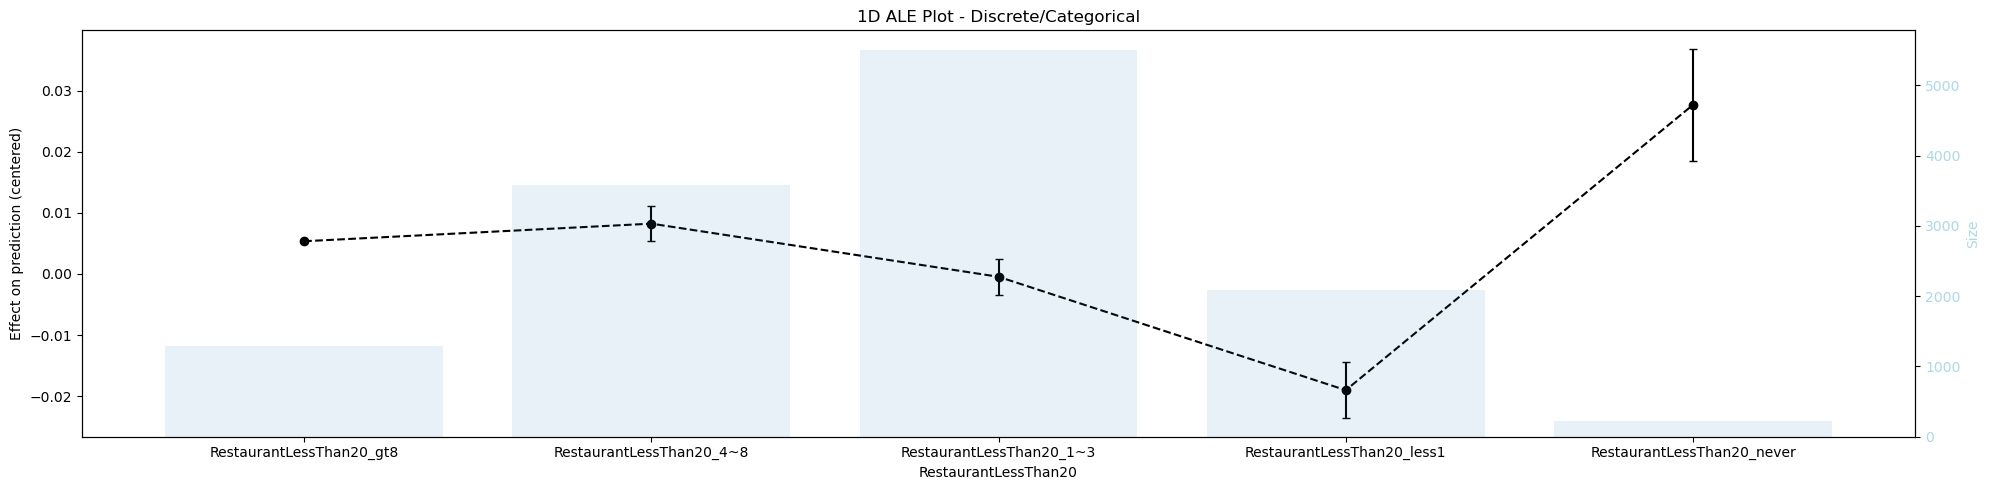

PyALE._ALE_generic:INFO: categorical feature detected.


Restaurant20To50


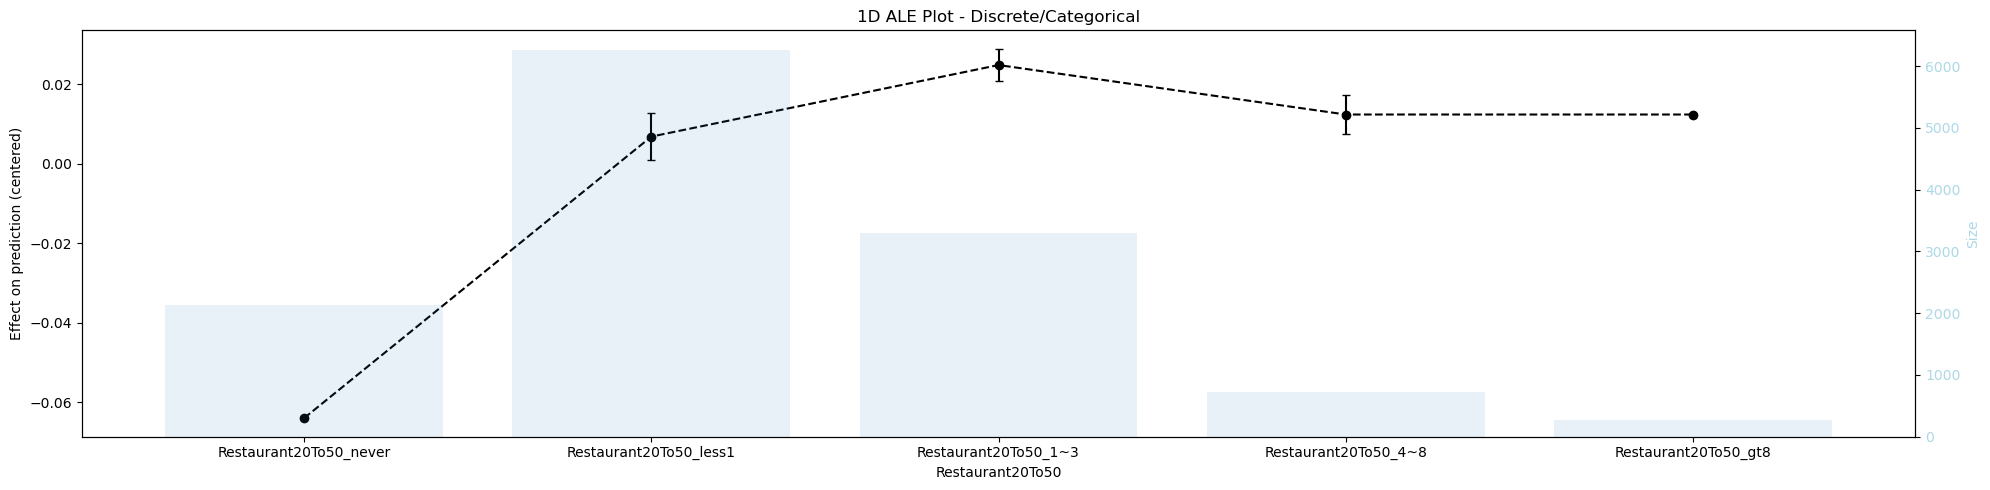

PyALE._ALE_generic:INFO: categorical feature detected.


toCoupon_GEQ15min


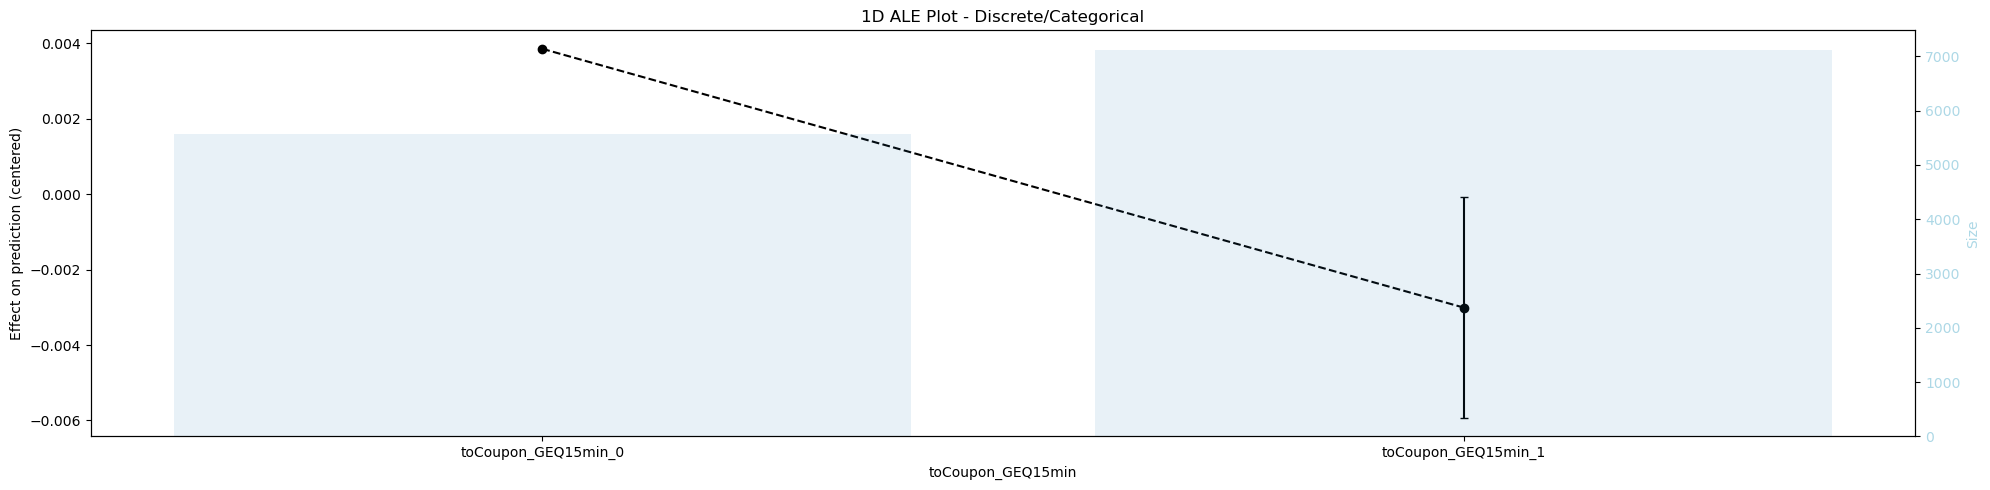

PyALE._ALE_generic:INFO: categorical feature detected.


toCoupon_GEQ25min


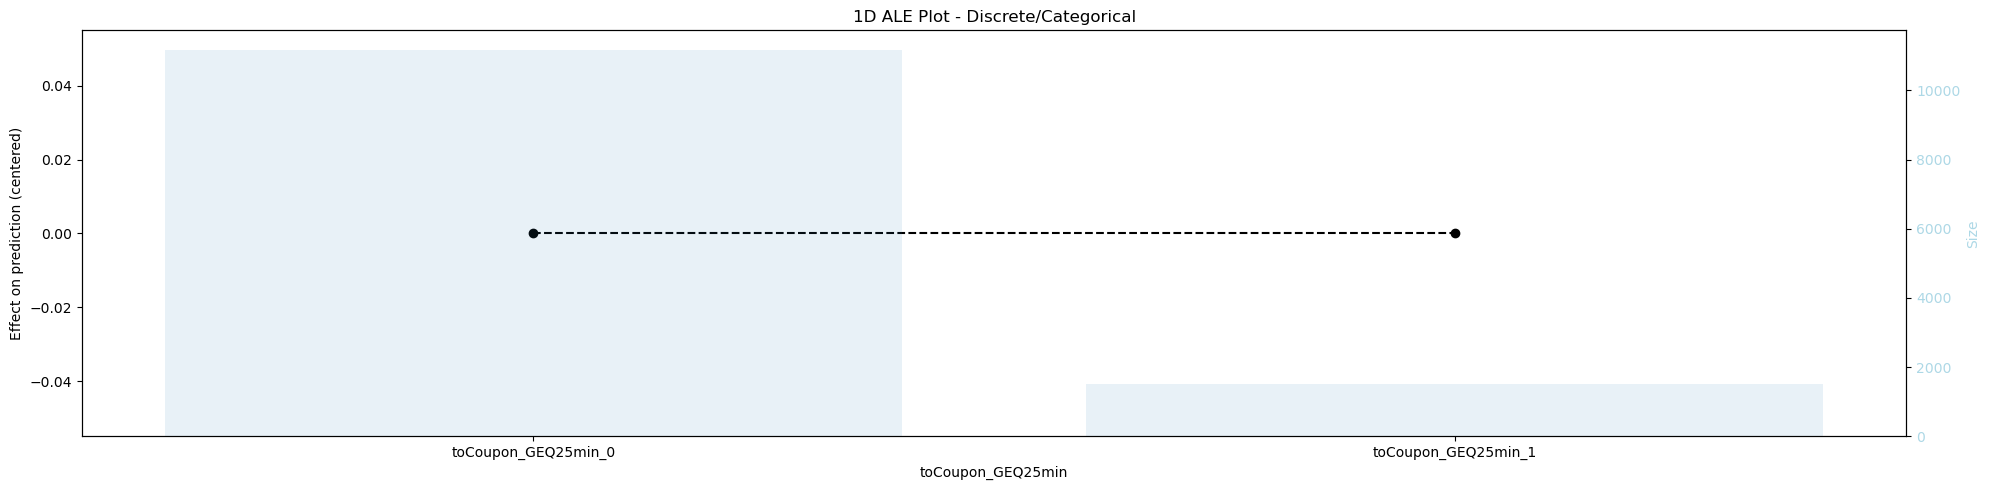

PyALE._ALE_generic:INFO: categorical feature detected.


direction_same


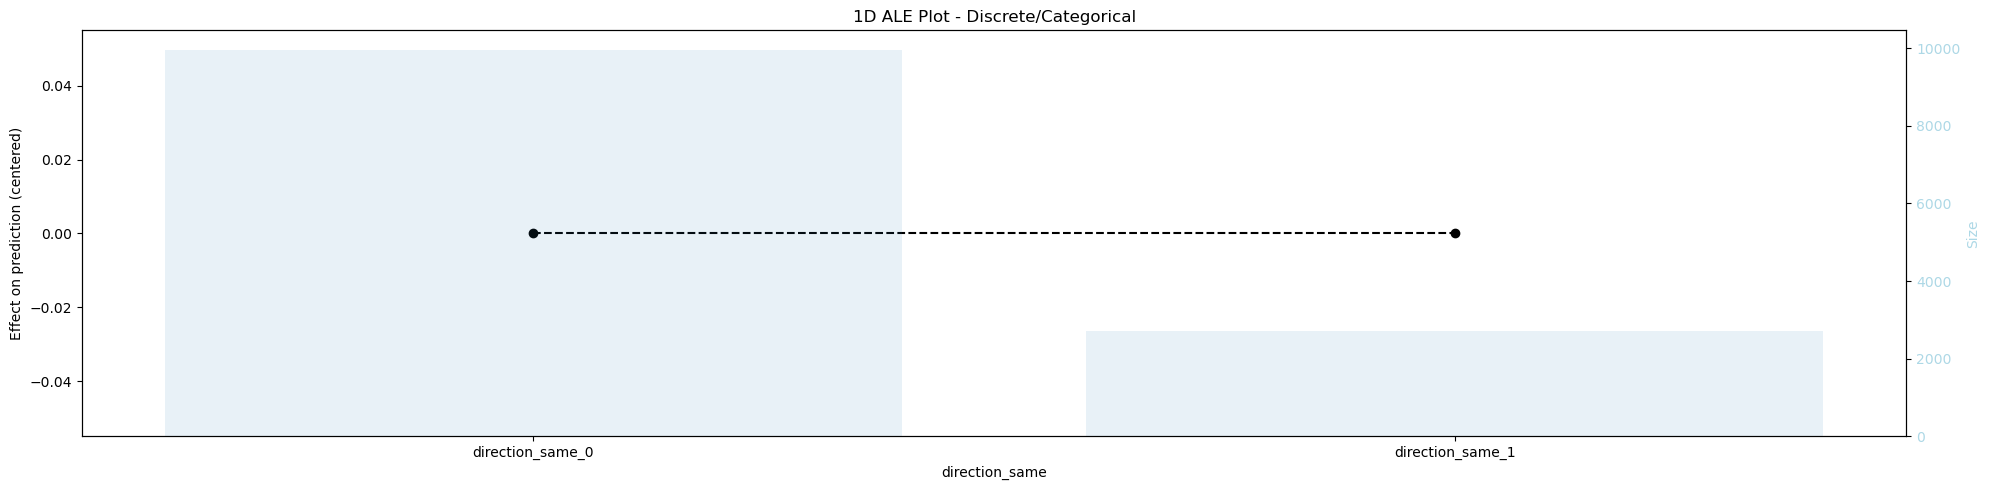

PyALE._ALE_generic:INFO: categorical feature detected.


direction_opp


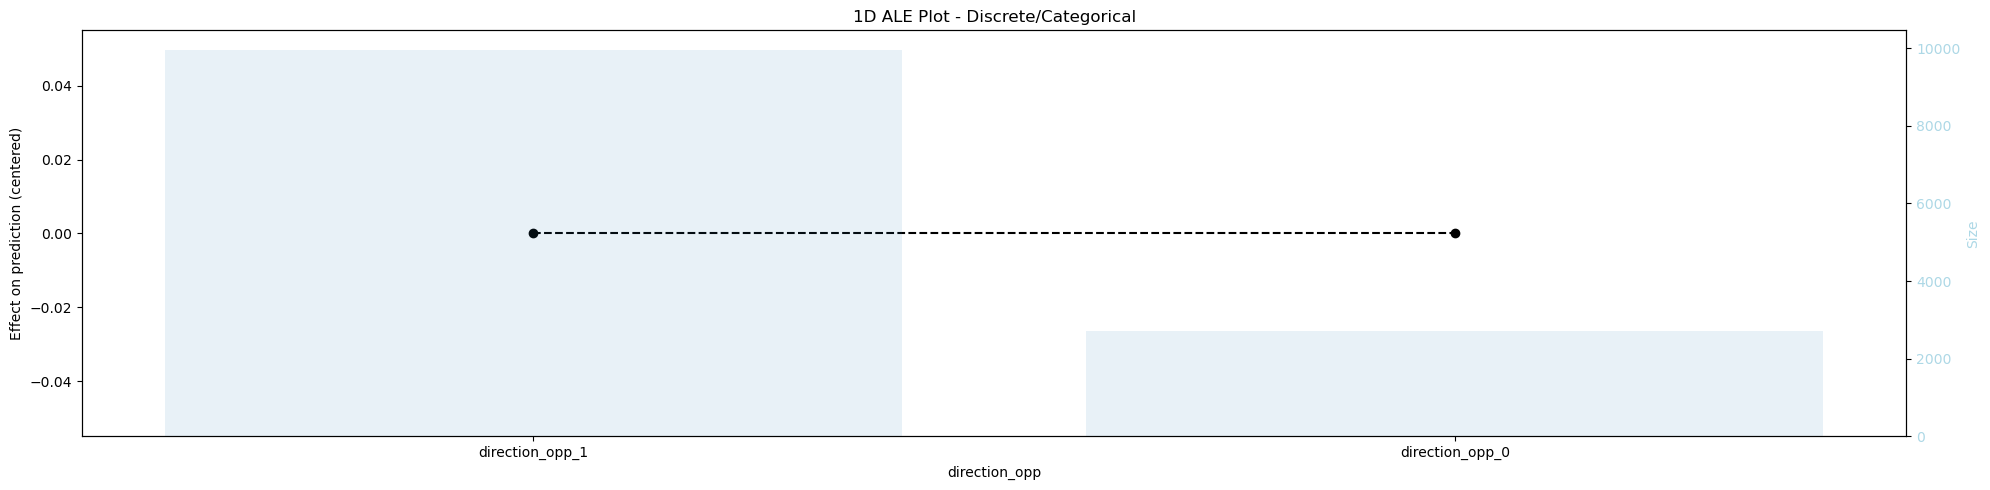

In [24]:
col_list = list(df.columns) # features to do ALEPlot
col_list.remove('toCoupon_GEQ5min') # only have one value - ALEPlot wont work
col_list.remove('Y') # label

for col in col_list:
    print(col)
    fig, ax = plt.subplots(figsize=(20, 5))
    hyeni_pyale(df,df_ohe,xgb,col,fig=fig,ax=ax)
    plt.show()